Imports

In [2]:
from models import ff_eucl
import ff_hyp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import geoopt
from time import time
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import hiddenlayer as hl
import helper
#torch.cuda.is_available()

#Disable Debugging APIs
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

#cuDNN Autotuner
torch.backends.cudnn.benchmark = True

#CUDA check

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#Data Transformation

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.1307,), (0.3081,)), 
                              ])

#Training, validation and test data

In [5]:
train_set = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
test_set = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)

size = len(train_set)
print(size)

train_data, val_data = torch.utils.data.random_split(train_set, [int(size-size*0.2), int(size*0.2)])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle= True, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle= True, num_workers=6, pin_memory=True)

60000


C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Initializing the model

In [6]:
# images, labels = next(iter(trainloader))
# images = images.view(images.shape[0], -1)
# grid = torchvision.utils.make_grid(images)
# tb = SummaryWriter()
# tb.add_image("images", grid)
# tb.add_graph(model, images)
# model.to(device)

In [7]:
from itertools import product
parameters = dict(
    lr = [0.1, 0.01, 0.001],
    batch_size = [64,128,256],
    shuffle = [True, False]
)

param_values = [v for v in parameters.values()]
print(param_values)

for lr,batch_size, shuffle in product(*param_values):
    print(lr, batch_size, shuffle)

[[0.1, 0.01, 0.001], [64, 128, 256], [True, False]]
0.1 64 True
0.1 64 False
0.1 128 True
0.1 128 False
0.1 256 True
0.1 256 False
0.01 64 True
0.01 64 False
0.01 128 True
0.01 128 False
0.01 256 True
0.01 256 False
0.001 64 True
0.001 64 False
0.001 128 True
0.001 128 False
0.001 256 True
0.001 256 False


Loss Function

In [8]:
#criterion = nn.CrossEntropyLoss()
# #criterion = nn.NLLLoss()
# images, labels = next(iter(trainloader))
# images, labels = images.to(device), labels.to(device)
# images = 0.0357*images.view(images.shape[0], -1)
# print(images)

# out = model(images) #output
# print(out)
# loss = criterion(out, labels) #calculate the loss

#Training, validating, prediction, and hyperparameter tuning functions

In [9]:
### Single prediction function
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

### Training function
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0
    total_correct = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        #images = ball.projx(images.view(images.shape[0], -1))
        # Training pass
        optimizer.zero_grad()
        # for param in model.parameters():
        #     param.grad = None

        output = model(images)
        loss = criterion(output, labels)  
        train_loss += loss.item()
        total_correct += get_num_correct(output, labels)
        #backpropagation
        loss.backward()      
        #Weight optimization
        optimizer.step()  

    return train_loss/len(dataloader.dataset) , total_correct

### Validation function
def val_epoch(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for  images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            #images = ball.projx(images.view(images.shape[0], -1))
            output = model(images)
            loss = criterion(output, labels)  
            val_loss += loss.item()
            val_correct += get_num_correct(output, labels)
    
    return val_loss/len(dataloader.dataset) , val_correct


### Hyperparameter tuning function
def hparams_tune(epochs):
    for run_id, (lr,batch_size, shuffle) in enumerate(product(*param_values)):
        print("run id:", run_id + 1)
        model = ff_eucl.EuclFF(784, 512, 256, 10, nn.ReLU())
        trainloader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, shuffle = shuffle)
        valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle= shuffle)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        comment = f' batch_size = {batch_size} lr = {lr} shuffle = {shuffle}'
        tb = SummaryWriter(comment=comment)
        
        for epoch in range(epochs):
            train_loss, total_correct = train_epoch(model, trainloader, optimizer, criterion)
            val_loss, val_correct = val_epoch(model, valloader, criterion)
                
            tb.add_scalar("Training Loss", train_loss, epoch)
            tb.add_scalar("Validation Loss", val_loss, epoch)
            tb.add_scalar("Training Accuracy", total_correct/len(train_data), epoch)
            tb.add_scalar("Validation Accuracy", val_correct/len(val_data), epoch)

            print("epoch:", epoch, "training loss:",train_loss, "validation loss:", val_loss,
            "training accuracy:", total_correct/len(train_data), "validation accuracy:", val_correct/len(val_data))
        
        tb.add_hparams(
                {"lr": lr, "bsize": batch_size, "shuffle":shuffle},
                {
                    "training accuracy": total_correct/ len(train_data),
                    "validation accuracy": val_correct/ len(val_data),
                    "training loss": train_loss,
                    "validation loss": val_loss,
                },
            )
    tb.close()

    return None

### Model evaluation
def model_eval(model, epochs, trainloader, valloader, optimizer, criterion):
    tb = SummaryWriter()
    t_loss = []
    v_loss = []
    t_accuracy = []
    v_accuracy = []
    epoch_values = []
    for epoch in range(epochs):
        train_loss, total_correct = train_epoch(model, trainloader, optimizer, criterion) 
        t_loss.append(train_loss)
        t_accuracy.append(total_correct/len(train_data))
        val_loss, val_correct = val_epoch(model, valloader, criterion)
        v_loss.append(val_loss)
        v_accuracy.append(val_correct/len(val_data))
        epoch_values.append(epoch)
        
        tb.add_scalar("Training Loss", train_loss, epoch)
        tb.add_scalar("Validation Loss", val_loss, epoch)
        tb.add_scalar("Training Accuracy", total_correct/len(train_data), epoch)
        tb.add_scalar("Validation Accuracy", val_correct/len(val_data), epoch)
        print("epoch:", epoch, "training loss:",train_loss, "validation loss:", val_loss,
        "training accuracy:", total_correct/len(train_data), "validation accuracy:", val_correct/len(val_data))


    return t_loss, v_loss, t_accuracy, v_accuracy, epoch_values


In [22]:

#model = ff_eucl.EuclFF(784, 512, 256, 10, nn.ReLU())
model = ff_hyp.HypFF(784, 512, 256, 10)
print(model)

epochs = 10
#Hyperparameter tuning
#hparams_tune(epochs)
#Model evaluation
lr=0.01
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.NLLLoss()

#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = geoopt.optim.RiemannianSGD(model.parameters(), lr=lr, momentum=0.9)
t_loss ,v_loss, t_accuracy, v_accuracy, epoch_values = model_eval(model, epochs, trainloader, valloader, optimizer, criterion)

HypFF(
  (act_fn): ReLU()
  (fc1): MobLinear(in_features=784, out_features=512, bias=True)
  (fc2): MobLinear(in_features=512, out_features=256, bias=True)
  (fc3): MobLinear(in_features=256, out_features=10, bias=True)
)
epoch: 0 training loss: 0.03086644694954157 validation loss: 0.024249858498573303 training accuracy: 0.49516666666666664 validation accuracy: 0.91975
epoch: 1 training loss: 0.023327251367270947 validation loss: 0.02308306203285853 training accuracy: 0.9484583333333333 validation accuracy: 0.9584166666666667
epoch: 2 training loss: 0.022846598687271277 validation loss: 0.02292772814631462 training accuracy: 0.9693958333333333 validation accuracy: 0.9668333333333333
epoch: 3 training loss: 0.02268262812246879 validation loss: 0.022858130147059758 training accuracy: 0.9791041666666667 validation accuracy: 0.96725
epoch: 4 training loss: 0.022585719409088295 validation loss: 0.02277275608976682 training accuracy: 0.9845208333333333 validation accuracy: 0.9754166666666667

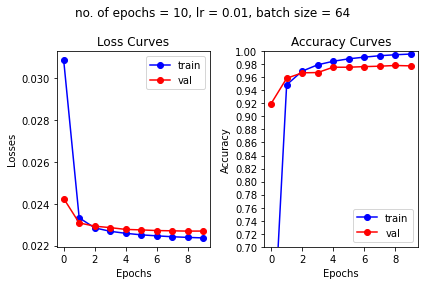

In [24]:
fig , (ax0, ax1) = plt.subplots(1, 2)

# ax0 = fig.add_subplot(121, title="Loss curves")
# ax1 = fig.add_subplot(122, title="Accuracy curves")
ax0.set_title('Loss Curves')
ax1.set_title('Accuracy Curves')
ax0.plot(epoch_values, t_loss, 'bo-', label='train')
ax0.plot(epoch_values, v_loss, 'ro-', label='val')
ax1.plot(epoch_values, t_accuracy, 'bo-', label='train')
ax1.plot(epoch_values, v_accuracy, 'ro-', label='val')

ax0.set_xlabel('Epochs')
ax1.set_xlabel('Epochs')
ax0.set_ylabel('Losses')
ax1.set_ylabel('Accuracy')
ax1.yaxis.set_ticks(np.arange(0.7, 1.0, 0.02))
ax1.set_ylim(0.7, 1.0)
ax0.legend()
ax1.legend()

fig.suptitle('no. of epochs = {}, lr = {}, batch size = 64'.format(epochs, lr))
fig.tight_layout()

In [12]:
model1 = ff_hyp.HypFF(784, 512, 256, 10)
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
grid = torchvision.utils.make_grid(images)
tb = SummaryWriter()
tb.add_image("images", grid)
tb.add_graph(model1, images)

C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:118: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  k = torch.as_tensor(k)
C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\jit\_trace.py:977: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 614 element(s) (out of 640) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.0007216241210699081 (0.005605527199804783 vs. 0.004883903078734875), which occurred at index (31, 5).
  _check_trace(


TracingCheckError: Tracing failed sanity checks!
ERROR: Graphs differed across invocations!
	Graph diff:
		  graph(%self.1 : __torch__.ff_hyp.HypFF,
		        %x.1 : Tensor):
		    %2 : __torch__.mobius.MobLinear = prim::GetAttr[name="fc3"](%self.1)
		    %3 : __torch__.mobius.MobLinear = prim::GetAttr[name="fc2"](%self.1)
		    %4 : __torch__.torch.nn.modules.activation.ReLU = prim::GetAttr[name="act_fn"](%self.1)
		    %5 : __torch__.mobius.MobLinear = prim::GetAttr[name="fc1"](%self.1)
		-   %6 : Tensor = prim::Constant[value={-0.330893}]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:118:0
		?                                       -   ^^^^^
		+   %6 : Tensor = prim::Constant[value={0.541325}]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:118:0
		?                                         +++ ^^
		    %7 : Device = prim::Constant[value="cpu"]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:118:0
		    %8 : int = prim::Constant[value=6]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:118:0
		    %9 : bool = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:118:0
		    %10 : bool = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:118:0
		    %11 : NoneType = prim::Constant()
		    %data : Tensor = aten::to(%6, %7, %8, %9, %10, %11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:118:0
		    %k.1 : Tensor = aten::detach(%data) # C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\parameter.py:26:0
		    %k.3 : Tensor = aten::exp_(%k.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:532:0
		    %15 : Tensor = prim::Constant[value={1}]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:532:0
		    %16 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:532:0
		    %k.5 : Tensor = aten::sub_(%k.3, %15, %16) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:532:0
		    %18 : Tensor = aten::log_(%k.5) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:532:0
		    %62 : int = prim::Constant[value=6]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:22
		    %63 : float = prim::Constant[value=0.0040000000000000001]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:317:18
		    %64 : float = prim::Constant[value=1000000000000000]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:59
		    %65 : bool = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:42
		    %66 : int = prim::Constant[value=2]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:31
		    %67 : float = prim::Constant[value=1.0000000000000001e-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:58
		    %68 : int = prim::Constant[value=-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:19
		    %69 : int = prim::Constant[value=15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:20
		    %70 : float = prim::Constant[value=0.33333333333333331]()
		    %71 : int = prim::Constant[value=3]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:59:18
		    %72 : float = prim::Constant[value=0.5]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:33
		    %73 : float = prim::Constant[value=9.9999999999999998e+37]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:56
		    %74 : int = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:27
		    %75 : float = prim::Constant[value=1.0000000000000001e-05]()
		    %76 : float = prim::Constant[value=1e-08]()
		    %77 : bool = prim::Constant[value=0]()
		    %78 : int = prim::Constant[value=-1](), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1052:0
		    %79 : int = prim::Constant[value=20](), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %80 : int = prim::Constant[value=1](), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %81 : Tensor = prim::Constant[value={0.541325}](), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %82 : NoneType = prim::Constant(), scope: __module.fc1
		    %83 : Tensor = prim::GetAttr[name="bias"](%5)
		    %84 : Tensor = prim::GetAttr[name="weight"](%5)
		    %u.1 : Tensor = aten::linear(%x.1, %84, %82), scope: __module.fc1 # C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1847:0
		    %86 : Tensor = aten::softplus(%81, %80, %79), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.7 : Tensor = aten::neg(%86), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %88 : int[] = prim::ListConstruct(%78)
		    %89 : Tensor = aten::norm(%u.1, %66, %88, %65) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %u_norm.5 : Tensor = aten::clamp_min(%89, %67) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %k_sign.15 : Tensor = aten::sign(%k.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:192:13
		    %92 : Device = prim::device(%k.7)
		    %93 : int = prim::dtype(%k.7)
		    %94 : int[] = prim::ListConstruct()
		    %zero.7 : Tensor = aten::zeros(%94, %93, %82, %92, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:193:11
		    %k_zero.7 : Tensor = aten::isclose(%k.7, %zero.7, %75, %76, %77) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:194:13
		    %97 : int = prim::dtype(%k_sign.15)
		    %98 : Tensor = aten::to(%zero.7, %97, %77, %77, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:47
		    %k_sign.17 : Tensor = aten::masked_fill(%k_sign.15, %k_zero.7, %98) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:13
		    %100 : Tensor = aten::all(%k_zero.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %101 : bool = aten::Bool(%100) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %102 : Tensor = prim::If(%101) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:4
		      block0():
		        %103 : Tensor = aten::sign(%k.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %104 : Tensor = aten::add(%103, %72, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %105 : Tensor = aten::sign(%104) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		        %k.58 : Tensor = aten::mul(%k.7, %105) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		        %107 : Tensor = aten::mul(%k.58, %70) # <string>:3:9
		        %108 : Tensor = aten::pow(%u_norm.5, %71) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		        %109 : Tensor = aten::mul(%107, %108) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		        %110 : Tensor = aten::add(%u_norm.5, %109, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		        -> (%110)
		      block1():
		        %111 : Tensor = aten::abs(%k.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %112 : Tensor = aten::add_(%111, %67, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %k_sqrt.15 : Tensor = aten::sqrt(%112) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:199:13
		        %scaled_x.15 : Tensor = aten::mul(%u_norm.5, %k_sqrt.15) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:200:15
		        %115 : Tensor = aten::lt(%k_sign.17, %74) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:17
		        %116 : Tensor = aten::all(%115) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %117 : bool = aten::Bool(%116) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %118 : Tensor = prim::If(%117) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:4
		          block0():
		            %119 : Tensor = aten::reciprocal(%k_sqrt.15) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            %120 : Tensor = aten::clamp(%scaled_x.15, %68, %69) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %121 : Tensor = aten::tanh(%120) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %122 : Tensor = aten::mul(%119, %121) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            -> (%122)
		          block1():
		            %123 : Tensor = aten::gt(%k_sign.17, %74) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:19
		            %124 : Tensor = aten::all(%123) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %125 : bool = aten::Bool(%124) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %126 : Tensor = prim::If(%125) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:4
		              block0():
		                %127 : Tensor = aten::reciprocal(%k_sqrt.15) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                %128 : Tensor = aten::clamp_max(%scaled_x.15, %73) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %129 : Tensor = aten::tan(%128) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %130 : Tensor = aten::mul(%127, %129) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                -> (%130)
		              block1():
		                %131 : Tensor = aten::gt(%k_sign.17, %74) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:24
		                %132 : Tensor = aten::clamp_max(%scaled_x.15, %73) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %133 : Tensor = aten::tan(%132) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %134 : Tensor = aten::clamp(%scaled_x.15, %68, %69) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %135 : Tensor = aten::tanh(%134) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %136 : Tensor = aten::where(%131, %133, %135) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %137 : Tensor = aten::reciprocal(%k_sqrt.15) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:209:14
		                %tan_k_nonzero.7 : Tensor = aten::mul(%136, %137) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %139 : Tensor = aten::sign(%k.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %140 : Tensor = aten::add(%139, %72, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %141 : Tensor = aten::sign(%140) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		                %k.70 : Tensor = aten::mul(%k.7, %141) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		                %143 : Tensor = aten::mul(%k.70, %70) # <string>:3:9
		                %144 : Tensor = aten::pow(%u_norm.5, %71) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		                %145 : Tensor = aten::mul(%143, %144) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		                %146 : Tensor = aten::add(%u_norm.5, %145, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		                %147 : Tensor = aten::where(%k_zero.7, %146, %tan_k_nonzero.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:211:15
		                -> (%147)
		            -> (%126)
		        -> (%118)
		    %148 : Tensor = aten::div(%u.1, %u_norm.5) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:34
		    %x.3 : Tensor = aten::mul(%102, %148) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:14
		    %150 : Tensor = aten::softplus(%81, %80, %79), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.9 : Tensor = aten::neg(%150), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %152 : int = prim::dtype(%x.3)
		    %153 : bool = aten::eq(%152, %62) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.29 : float = prim::If(%153) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%63)
		      block1():
		        -> (%75)
		    %155 : float = aten::sub(%80, %eps.29) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %156 : Tensor = aten::abs(%k.9) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %157 : Tensor = aten::add_(%156, %67, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %158 : Tensor = aten::pow(%157, %72) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %159 : Tensor = aten::reciprocal(%158) # <string>:21:9
		    %maxnorm.9 : Tensor = aten::mul(%159, %155) # <string>:21:9
		    %161 : Tensor = aten::lt(%k.9, %74) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %162 : int[] = prim::ListConstruct()
		    %163 : Tensor = aten::new_full(%k.9, %162, %64, %82, %82, %82, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.11 : Tensor = aten::where(%161, %maxnorm.9, %163) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %165 : int[] = prim::ListConstruct(%78)
		    %166 : Tensor = aten::norm(%x.3, %66, %165, %65) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.5 : Tensor = aten::clamp_min(%166, %67) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.5 : Tensor = aten::gt(%norm.5, %maxnorm.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %169 : Tensor = aten::div(%x.3, %norm.5) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.5 : Tensor = aten::mul(%169, %maxnorm.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %x.7 : Tensor = aten::where(%cond.5, %projected.5, %x.3) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %172 : Tensor = aten::softplus(%81, %80, %79), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.11 : Tensor = aten::neg(%172), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %174 : int[] = prim::ListConstruct(%78)
		    %175 : Tensor = aten::norm(%83, %66, %174, %65) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %u_norm.3 : Tensor = aten::clamp_min(%175, %67) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %k_sign.3 : Tensor = aten::sign(%k.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:192:13
		    %178 : Device = prim::device(%k.11)
		    %179 : int = prim::dtype(%k.11)
		    %180 : int[] = prim::ListConstruct()
		    %zero.3 : Tensor = aten::zeros(%180, %179, %82, %178, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:193:11
		    %k_zero.3 : Tensor = aten::isclose(%k.11, %zero.3, %75, %76, %77) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:194:13
		    %183 : int = prim::dtype(%k_sign.3)
		    %184 : Tensor = aten::to(%zero.3, %183, %77, %77, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:47
		    %k_sign.9 : Tensor = aten::masked_fill(%k_sign.3, %k_zero.3, %184) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:13
		    %186 : Tensor = aten::all(%k_zero.3) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %187 : bool = aten::Bool(%186) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %188 : Tensor = prim::If(%187) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:4
		      block0():
		        %189 : Tensor = aten::sign(%k.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %190 : Tensor = aten::add(%189, %72, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %191 : Tensor = aten::sign(%190) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		        %k.52 : Tensor = aten::mul(%k.11, %191) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		        %193 : Tensor = aten::mul(%k.52, %70) # <string>:3:9
		        %194 : Tensor = aten::pow(%u_norm.3, %71) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		        %195 : Tensor = aten::mul(%193, %194) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		        %196 : Tensor = aten::add(%u_norm.3, %195, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		        -> (%196)
		      block1():
		        %197 : Tensor = aten::abs(%k.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %198 : Tensor = aten::add_(%197, %67, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %k_sqrt.11 : Tensor = aten::sqrt(%198) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:199:13
		        %scaled_x.11 : Tensor = aten::mul(%u_norm.3, %k_sqrt.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:200:15
		        %201 : Tensor = aten::lt(%k_sign.9, %74) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:17
		        %202 : Tensor = aten::all(%201) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %203 : bool = aten::Bool(%202) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %204 : Tensor = prim::If(%203) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:4
		          block0():
		            %205 : Tensor = aten::reciprocal(%k_sqrt.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            %206 : Tensor = aten::clamp(%scaled_x.11, %68, %69) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %207 : Tensor = aten::tanh(%206) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %208 : Tensor = aten::mul(%205, %207) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            -> (%208)
		          block1():
		            %209 : Tensor = aten::gt(%k_sign.9, %74) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:19
		            %210 : Tensor = aten::all(%209) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %211 : bool = aten::Bool(%210) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %212 : Tensor = prim::If(%211) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:4
		              block0():
		                %213 : Tensor = aten::reciprocal(%k_sqrt.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                %214 : Tensor = aten::clamp_max(%scaled_x.11, %73) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %215 : Tensor = aten::tan(%214) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %216 : Tensor = aten::mul(%213, %215) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                -> (%216)
		              block1():
		                %217 : Tensor = aten::gt(%k_sign.9, %74) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:24
		                %218 : Tensor = aten::clamp_max(%scaled_x.11, %73) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %219 : Tensor = aten::tan(%218) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %220 : Tensor = aten::clamp(%scaled_x.11, %68, %69) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %221 : Tensor = aten::tanh(%220) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %222 : Tensor = aten::where(%217, %219, %221) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %223 : Tensor = aten::reciprocal(%k_sqrt.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:209:14
		                %tan_k_nonzero.5 : Tensor = aten::mul(%222, %223) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %225 : Tensor = aten::sign(%k.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %226 : Tensor = aten::add(%225, %72, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %227 : Tensor = aten::sign(%226) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		                %k.44 : Tensor = aten::mul(%k.11, %227) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		                %229 : Tensor = aten::mul(%k.44, %70) # <string>:3:9
		                %230 : Tensor = aten::pow(%u_norm.3, %71) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		                %231 : Tensor = aten::mul(%229, %230) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		                %232 : Tensor = aten::add(%u_norm.3, %231, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		                %233 : Tensor = aten::where(%k_zero.3, %232, %tan_k_nonzero.5) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:211:15
		                -> (%233)
		            -> (%212)
		        -> (%204)
		    %234 : Tensor = aten::div(%83, %u_norm.3) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:34
		    %x.8 : Tensor = aten::mul(%188, %234) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:14
		    %236 : Tensor = aten::softplus(%81, %80, %79), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.13 : Tensor = aten::neg(%236), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %238 : int = prim::dtype(%x.8)
		    %239 : bool = aten::eq(%238, %62) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.31 : float = prim::If(%239) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%63)
		      block1():
		        -> (%75)
		    %241 : float = aten::sub(%80, %eps.31) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %242 : Tensor = aten::abs(%k.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %243 : Tensor = aten::add_(%242, %67, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %244 : Tensor = aten::pow(%243, %72) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %245 : Tensor = aten::reciprocal(%244) # <string>:21:9
		    %maxnorm.13 : Tensor = aten::mul(%245, %241) # <string>:21:9
		    %247 : Tensor = aten::lt(%k.13, %74) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %248 : int[] = prim::ListConstruct()
		    %249 : Tensor = aten::new_full(%k.13, %248, %64, %82, %82, %82, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.15 : Tensor = aten::where(%247, %maxnorm.13, %249) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %251 : int[] = prim::ListConstruct(%78)
		    %252 : Tensor = aten::norm(%x.8, %66, %251, %65) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.7 : Tensor = aten::clamp_min(%252, %67) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.7 : Tensor = aten::gt(%norm.7, %maxnorm.15) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %255 : Tensor = aten::div(%x.8, %norm.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.7 : Tensor = aten::mul(%255, %maxnorm.15) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %y.1 : Tensor = aten::where(%cond.7, %projected.7, %x.8) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %258 : Tensor = aten::softplus(%81, %80, %79), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.15 : Tensor = aten::neg(%258), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %260 : Tensor = aten::pow(%x.7, %66) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:511:9
		    %261 : int[] = prim::ListConstruct(%78)
		    %x2.2 : Tensor = aten::sum(%260, %261, %65, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:511:9
		    %263 : Tensor = aten::pow(%y.1, %66) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:512:9
		    %264 : int[] = prim::ListConstruct(%78)
		    %y2.2 : Tensor = aten::sum(%263, %264, %65, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:512:9
		    %266 : Tensor = aten::mul(%x.7, %y.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:513:10
		    %267 : int[] = prim::ListConstruct(%78)
		    %xy.2 : Tensor = aten::sum(%266, %267, %65, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:513:10
		    %269 : Tensor = aten::mul(%k.15, %66) # <string>:3:9
		    %270 : Tensor = aten::mul(%269, %xy.2) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:15
		    %271 : Tensor = aten::neg(%270) # <string>:19:9
		    %272 : Tensor = aten::add(%271, %80, %80) # <string>:19:9
		    %273 : Tensor = aten::mul(%k.15, %y2.2) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:28
		    %274 : Tensor = aten::sub(%272, %273, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:11
		    %275 : Tensor = aten::mul(%274, %x.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:11
		    %276 : Tensor = aten::mul(%k.15, %x2.2) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:47
		    %277 : Tensor = aten::add(%276, %80, %80) # <string>:5:9
		    %278 : Tensor = aten::mul(%277, %y.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:43
		    %num.2 : Tensor = aten::add(%275, %278, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:11
		    %280 : Tensor = aten::mul(%k.15, %66) # <string>:3:9
		    %281 : Tensor = aten::mul(%280, %xy.2) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:16
		    %282 : Tensor = aten::neg(%281) # <string>:19:9
		    %283 : Tensor = aten::add(%282, %80, %80) # <string>:19:9
		    %284 : Tensor = aten::pow(%k.15, %66) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:29
		    %285 : Tensor = aten::mul(%284, %x2.2) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:29
		    %286 : Tensor = aten::mul(%285, %y2.2) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:29
		    %denom.2 : Tensor = aten::add(%283, %286, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:12
		    %288 : Tensor = aten::clamp_min(%denom.2, %67) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:528:17
		    %x.9 : Tensor = aten::div(%num.2, %288) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:528:11
		    %290 : Tensor = aten::softplus(%81, %80, %79), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.17 : Tensor = aten::neg(%290), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %292 : int = prim::dtype(%x.9)
		    %293 : bool = aten::eq(%292, %62) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.35 : float = prim::If(%293) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%63)
		      block1():
		        -> (%75)
		    %295 : float = aten::sub(%80, %eps.35) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %296 : Tensor = aten::abs(%k.17) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %297 : Tensor = aten::add_(%296, %67, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %298 : Tensor = aten::pow(%297, %72) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %299 : Tensor = aten::reciprocal(%298) # <string>:21:9
		    %maxnorm.17 : Tensor = aten::mul(%299, %295) # <string>:21:9
		    %301 : Tensor = aten::lt(%k.17, %74) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %302 : int[] = prim::ListConstruct()
		    %303 : Tensor = aten::new_full(%k.17, %302, %64, %82, %82, %82, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.19 : Tensor = aten::where(%301, %maxnorm.17, %303) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %305 : int[] = prim::ListConstruct(%78)
		    %306 : Tensor = aten::norm(%x.9, %66, %305, %65) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.9 : Tensor = aten::clamp_min(%306, %67) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.9 : Tensor = aten::gt(%norm.9, %maxnorm.19) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %309 : Tensor = aten::div(%x.9, %norm.9) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.9 : Tensor = aten::mul(%309, %maxnorm.19) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %x.11 : Tensor = aten::where(%cond.9, %projected.9, %x.9) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %312 : Tensor = aten::softplus(%81, %80, %79), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.19 : Tensor = aten::neg(%312), scope: __module.fc1 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %314 : int = prim::dtype(%x.11)
		    %315 : bool = aten::eq(%314, %62) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.27 : float = prim::If(%315) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%63)
		      block1():
		        -> (%75)
		    %317 : float = aten::sub(%80, %eps.27) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %318 : Tensor = aten::abs(%k.19) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %319 : Tensor = aten::add_(%318, %67, %80) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %320 : Tensor = aten::pow(%319, %72) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %321 : Tensor = aten::reciprocal(%320) # <string>:21:9
		    %maxnorm.3 : Tensor = aten::mul(%321, %317) # <string>:21:9
		    %323 : Tensor = aten::lt(%k.19, %74) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %324 : int[] = prim::ListConstruct()
		    %325 : Tensor = aten::new_full(%k.19, %324, %64, %82, %82, %82, %82) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.7 : Tensor = aten::where(%323, %maxnorm.3, %325) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %327 : int[] = prim::ListConstruct(%78)
		    %328 : Tensor = aten::norm(%x.11, %66, %327, %65) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.3 : Tensor = aten::clamp_min(%328, %67) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.3 : Tensor = aten::gt(%norm.3, %maxnorm.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %331 : Tensor = aten::div(%x.11, %norm.3) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.3 : Tensor = aten::mul(%331, %maxnorm.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %x.13 : Tensor = aten::where(%cond.3, %projected.3, %x.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %334 : (Tensor, Tensor) = prim::TupleConstruct(%x.13, %81)
		    %20 : Tensor, %21 : Tensor = prim::TupleUnpack(%334)
		    %22 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %23 : int = prim::Constant[value=20]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %24 : Tensor = aten::softplus(%18, %22, %23) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.21 : Tensor = aten::neg(%24) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %26 : int = prim::Constant[value=-1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1389:0
		    %27 : Function = prim::Constant[name="_logmap0"]()
		    %335 : bool = prim::Constant[value=0]()
		    %336 : float = prim::Constant[value=1e-08]()
		    %337 : float = prim::Constant[value=1.0000000000000001e-05]()
		    %338 : NoneType = prim::Constant()
		    %339 : int = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:226:27
		    %340 : float = prim::Constant[value=0.5]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:33
		    %341 : int = prim::Constant[value=3]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:97:18
		    %342 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:94:17
		    %343 : float = prim::Constant[value=0.33333333333333331]()
		    %344 : float = prim::Constant[value=-0.99999990000000005]()
		    %345 : float = prim::Constant[value=0.99999990000000005]()
		    %346 : float = prim::Constant[value=1.0000000000000001e-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1192:58
		    %347 : int = prim::Constant[value=2]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1192:31
		    %348 : bool = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1192:42
		    %349 : Function = prim::Constant[name="artan_k"]()
		    %350 : int[] = prim::ListConstruct(%26)
		    %351 : Tensor = aten::norm(%20, %347, %350, %348) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1192:13
		    %y_norm.2 : Tensor = aten::clamp_min(%351, %346) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1192:13
		    %353 : Tensor = aten::div(%20, %y_norm.2) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1193:12
		    %k_sign.11 : Tensor = aten::sign(%k.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:216:13
		    %355 : Device = prim::device(%k.21)
		    %356 : int = prim::dtype(%k.21)
		    %357 : int[] = prim::ListConstruct()
		    %zero.5 : Tensor = aten::zeros(%357, %356, %338, %355, %338) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:217:11
		    %k_zero.5 : Tensor = aten::isclose(%k.21, %zero.5, %337, %336, %335) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:218:13
		    %360 : int = prim::dtype(%k_sign.11)
		    %361 : Tensor = aten::to(%zero.5, %360, %335, %335, %338) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:220:47
		    %k_sign.13 : Tensor = aten::masked_fill(%k_sign.11, %k_zero.5, %361) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:220:13
		    %363 : Tensor = aten::all(%k_zero.5) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:221:7
		    %364 : bool = aten::Bool(%363) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:221:7
		    %365 : Tensor = prim::If(%364) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:221:4
		      block0():
		        %366 : Tensor = aten::sign(%k.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %367 : Tensor = aten::add(%366, %340, %342) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %368 : Tensor = aten::sign(%367) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		        %k.46 : Tensor = aten::mul(%k.21, %368) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		        %370 : Tensor = aten::mul(%k.46, %343) # <string>:3:9
		        %371 : Tensor = aten::pow(%y_norm.2, %341) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:31
		        %372 : Tensor = aten::mul(%370, %371) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:19
		        %373 : Tensor = aten::sub(%y_norm.2, %372, %342) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:15
		        -> (%373)
		      block1():
		        %374 : Tensor = aten::abs(%k.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %375 : Tensor = aten::add_(%374, %346, %342) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %k_sqrt.13 : Tensor = aten::sqrt(%375) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:223:13
		        %scaled_x.13 : Tensor = aten::mul(%y_norm.2, %k_sqrt.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:224:15
		        %378 : Tensor = aten::lt(%k_sign.13, %339) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:226:17
		        %379 : Tensor = aten::all(%378) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:226:7
		        %380 : bool = aten::Bool(%379) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:226:7
		        %381 : Tensor = prim::If(%380) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:226:4
		          block0():
		            %382 : Tensor = aten::reciprocal(%k_sqrt.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:227:15
		            %x.18 : Tensor = aten::clamp(%scaled_x.13, %344, %345) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:36:8
		            %384 : Tensor = aten::add(%x.18, %342, %342) # <string>:5:9
		            %385 : Tensor = aten::log(%384) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		            %386 : Tensor = aten::neg(%x.18) # <string>:19:9
		            %387 : Tensor = aten::add(%386, %342, %342) # <string>:19:9
		            %388 : Tensor = aten::log(%387) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:33
		            %389 : Tensor = aten::sub(%385, %388, %342) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		            %390 : Tensor = aten::mul(%389, %340) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		            %391 : Tensor = aten::mul(%382, %390) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:227:15
		            -> (%391)
		          block1():
		            %392 : Tensor = aten::gt(%k_sign.13, %339) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:228:19
		            %393 : Tensor = aten::all(%392) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:228:9
		            %394 : bool = aten::Bool(%393) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:228:9
		            %395 : Tensor = prim::If(%394) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:228:4
		              block0():
		                %396 : Tensor = aten::reciprocal(%k_sqrt.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:229:15
		                %397 : Tensor = aten::atan(%scaled_x.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:229:37
		                %398 : Tensor = aten::mul(%396, %397) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:229:15
		                -> (%398)
		              block1():
		                %399 : Tensor = aten::gt(%k_sign.13, %339) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:232:24
		                %400 : Tensor = aten::atan(%scaled_x.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:232:38
		                %x.20 : Tensor = aten::clamp(%scaled_x.13, %344, %345) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:36:8
		                %402 : Tensor = aten::add(%x.20, %342, %342) # <string>:5:9
		                %403 : Tensor = aten::log(%402) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		                %404 : Tensor = aten::neg(%x.20) # <string>:19:9
		                %405 : Tensor = aten::add(%404, %342, %342) # <string>:19:9
		                %406 : Tensor = aten::log(%405) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:33
		                %407 : Tensor = aten::sub(%403, %406, %342) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		                %408 : Tensor = aten::mul(%407, %340) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		                %409 : Tensor = aten::where(%399, %400, %408) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:232:12
		                %410 : Tensor = aten::reciprocal(%k_sqrt.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:233:14
		                %artan_k_nonzero.4 : Tensor = aten::mul(%409, %410) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:232:12
		                %412 : Tensor = aten::sign(%k.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %413 : Tensor = aten::add(%412, %340, %342) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %414 : Tensor = aten::sign(%413) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		                %k.48 : Tensor = aten::mul(%k.21, %414) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		                %416 : Tensor = aten::mul(%k.48, %343) # <string>:3:9
		                %417 : Tensor = aten::pow(%y_norm.2, %341) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:31
		                %418 : Tensor = aten::mul(%416, %417) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:19
		                %419 : Tensor = aten::sub(%y_norm.2, %418, %342) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:15
		                %420 : Tensor = aten::where(%k_zero.5, %419, %artan_k_nonzero.4) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:235:15
		                -> (%420)
		            -> (%395)
		        -> (%381)
		    %input.1 : Tensor = aten::mul(%353, %365) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1193:12
		    %ex.1 : Tensor = aten::relu(%input.1), scope: __module.act_fn # C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1298:0
		    %30 : int = prim::Constant[value=-1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1391:0
		    %31 : Function = prim::Constant[name="_expmap0"]()
		    %423 : bool = prim::Constant[value=0]()
		    %424 : float = prim::Constant[value=1e-08]()
		    %425 : float = prim::Constant[value=1.0000000000000001e-05]()
		    %426 : NoneType = prim::Constant()
		    %427 : int = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:27
		    %428 : float = prim::Constant[value=9.9999999999999998e+37]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:56
		    %429 : float = prim::Constant[value=0.5]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:33
		    %430 : int = prim::Constant[value=3]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:59:18
		    %431 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:56:17
		    %432 : float = prim::Constant[value=0.33333333333333331]()
		    %433 : int = prim::Constant[value=15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:20
		    %434 : int = prim::Constant[value=-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:19
		    %435 : float = prim::Constant[value=1.0000000000000001e-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:58
		    %436 : int = prim::Constant[value=2]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:31
		    %437 : bool = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:42
		    %438 : Function = prim::Constant[name="tan_k"]()
		    %439 : int[] = prim::ListConstruct(%30)
		    %440 : Tensor = aten::norm(%ex.1, %436, %439, %437) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %u_norm.7 : Tensor = aten::clamp_min(%440, %435) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %k_sign.19 : Tensor = aten::sign(%k.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:192:13
		    %443 : Device = prim::device(%k.21)
		    %444 : int = prim::dtype(%k.21)
		    %445 : int[] = prim::ListConstruct()
		    %zero.9 : Tensor = aten::zeros(%445, %444, %426, %443, %426) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:193:11
		    %k_zero.9 : Tensor = aten::isclose(%k.21, %zero.9, %425, %424, %423) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:194:13
		    %448 : int = prim::dtype(%k_sign.19)
		    %449 : Tensor = aten::to(%zero.9, %448, %423, %423, %426) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:47
		    %k_sign.21 : Tensor = aten::masked_fill(%k_sign.19, %k_zero.9, %449) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:13
		    %451 : Tensor = aten::all(%k_zero.9) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %452 : bool = aten::Bool(%451) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %453 : Tensor = prim::If(%452) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:4
		      block0():
		        %454 : Tensor = aten::sign(%k.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %455 : Tensor = aten::add(%454, %429, %431) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %456 : Tensor = aten::sign(%455) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		        %k.54 : Tensor = aten::mul(%k.21, %456) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		        %458 : Tensor = aten::mul(%k.54, %432) # <string>:3:9
		        %459 : Tensor = aten::pow(%u_norm.7, %430) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		        %460 : Tensor = aten::mul(%458, %459) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		        %461 : Tensor = aten::add(%u_norm.7, %460, %431) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		        -> (%461)
		      block1():
		        %462 : Tensor = aten::abs(%k.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %463 : Tensor = aten::add_(%462, %435, %431) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %k_sqrt.17 : Tensor = aten::sqrt(%463) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:199:13
		        %scaled_x.17 : Tensor = aten::mul(%u_norm.7, %k_sqrt.17) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:200:15
		        %466 : Tensor = aten::lt(%k_sign.21, %427) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:17
		        %467 : Tensor = aten::all(%466) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %468 : bool = aten::Bool(%467) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %469 : Tensor = prim::If(%468) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:4
		          block0():
		            %470 : Tensor = aten::reciprocal(%k_sqrt.17) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            %471 : Tensor = aten::clamp(%scaled_x.17, %434, %433) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %472 : Tensor = aten::tanh(%471) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %473 : Tensor = aten::mul(%470, %472) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            -> (%473)
		          block1():
		            %474 : Tensor = aten::gt(%k_sign.21, %427) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:19
		            %475 : Tensor = aten::all(%474) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %476 : bool = aten::Bool(%475) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %477 : Tensor = prim::If(%476) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:4
		              block0():
		                %478 : Tensor = aten::reciprocal(%k_sqrt.17) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                %479 : Tensor = aten::clamp_max(%scaled_x.17, %428) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %480 : Tensor = aten::tan(%479) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %481 : Tensor = aten::mul(%478, %480) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                -> (%481)
		              block1():
		                %482 : Tensor = aten::gt(%k_sign.21, %427) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:24
		                %483 : Tensor = aten::clamp_max(%scaled_x.17, %428) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %484 : Tensor = aten::tan(%483) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %485 : Tensor = aten::clamp(%scaled_x.17, %434, %433) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %486 : Tensor = aten::tanh(%485) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %487 : Tensor = aten::where(%482, %484, %486) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %488 : Tensor = aten::reciprocal(%k_sqrt.17) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:209:14
		                %tan_k_nonzero.9 : Tensor = aten::mul(%487, %488) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %490 : Tensor = aten::sign(%k.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %491 : Tensor = aten::add(%490, %429, %431) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %492 : Tensor = aten::sign(%491) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		                %k.56 : Tensor = aten::mul(%k.21, %492) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		                %494 : Tensor = aten::mul(%k.56, %432) # <string>:3:9
		                %495 : Tensor = aten::pow(%u_norm.7, %430) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		                %496 : Tensor = aten::mul(%494, %495) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		                %497 : Tensor = aten::add(%u_norm.7, %496, %431) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		                %498 : Tensor = aten::where(%k_zero.9, %497, %tan_k_nonzero.9) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:211:15
		                -> (%498)
		            -> (%477)
		        -> (%469)
		    %499 : Tensor = aten::div(%ex.1, %u_norm.7) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:34
		    %x.15 : Tensor = aten::mul(%453, %499) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:14
		    %33 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %34 : int = prim::Constant[value=20]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %35 : Tensor = aten::softplus(%18, %33, %34) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.23 : Tensor = aten::neg(%35) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %37 : int = prim::Constant[value=-1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:310:0
		    %38 : float = prim::Constant[value=-1.]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:310:0
		    %39 : Function = prim::Constant[name="_project"]()
		    %501 : float = prim::Constant[value=1.0000000000000001e-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:56
		    %502 : int = prim::Constant[value=2]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:43
		    %503 : float = prim::Constant[value=1000000000000000]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:59
		    %504 : float = prim::Constant[value=0.5]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:38
		    %505 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %506 : float = prim::Constant[value=1.0000000000000001e-05]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:319:18
		    %507 : float = prim::Constant[value=0.0040000000000000001]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:317:18
		    %508 : int = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:315:13
		    %509 : int = prim::Constant[value=6]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:22
		    %510 : Function = prim::Constant[name="sabs"]()
		    %511 : NoneType = prim::Constant()
		    %512 : bool = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:35
		    %513 : bool = aten::lt(%38, %508) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:315:7
		    %eps.39 : float = prim::If(%513) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:315:4
		      block0():
		        %515 : int = prim::dtype(%x.15)
		        %516 : bool = aten::eq(%515, %509) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		        %eps.37 : float = prim::If(%516) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		          block0():
		            -> (%507)
		          block1():
		            -> (%506)
		        -> (%eps.37)
		      block1():
		        -> (%38)
		    %518 : float = aten::sub(%505, %eps.39) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %519 : Tensor = aten::abs(%k.23) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %520 : Tensor = aten::add_(%519, %501, %505) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %521 : Tensor = aten::pow(%520, %504) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %522 : Tensor = aten::reciprocal(%521) # <string>:21:9
		    %maxnorm.21 : Tensor = aten::mul(%522, %518) # <string>:21:9
		    %524 : Tensor = aten::lt(%k.23, %508) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %525 : int[] = prim::ListConstruct()
		    %526 : Tensor = aten::new_full(%k.23, %525, %503, %511, %511, %511, %511) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.23 : Tensor = aten::where(%524, %maxnorm.21, %526) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %528 : int[] = prim::ListConstruct(%37)
		    %529 : Tensor = aten::norm(%x.15, %502, %528, %512) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.11 : Tensor = aten::clamp_min(%529, %501) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.11 : Tensor = aten::gt(%norm.11, %maxnorm.23) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %532 : Tensor = aten::div(%x.15, %norm.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.11 : Tensor = aten::mul(%532, %maxnorm.23) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %input.3 : Tensor = aten::where(%cond.11, %projected.11, %x.15) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %535 : int = prim::Constant[value=6]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:22
		    %536 : float = prim::Constant[value=0.0040000000000000001]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:317:18
		    %537 : float = prim::Constant[value=1000000000000000]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:59
		    %538 : bool = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:42
		    %539 : int = prim::Constant[value=2]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:31
		    %540 : float = prim::Constant[value=1.0000000000000001e-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:58
		    %541 : int = prim::Constant[value=-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:19
		    %542 : int = prim::Constant[value=15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:20
		    %543 : float = prim::Constant[value=0.33333333333333331]()
		    %544 : int = prim::Constant[value=3]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:59:18
		    %545 : float = prim::Constant[value=0.5]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:33
		    %546 : float = prim::Constant[value=9.9999999999999998e+37]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:56
		    %547 : int = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:27
		    %548 : float = prim::Constant[value=1.0000000000000001e-05]()
		    %549 : float = prim::Constant[value=1e-08]()
		    %550 : bool = prim::Constant[value=0]()
		    %551 : int = prim::Constant[value=-1](), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1052:0
		    %552 : int = prim::Constant[value=20](), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %553 : int = prim::Constant[value=1](), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %554 : NoneType = prim::Constant(), scope: __module.fc2
		    %555 : Tensor = prim::GetAttr[name="bias"](%3)
		    %556 : Tensor = prim::GetAttr[name="weight"](%3)
		    %u.5 : Tensor = aten::linear(%input.3, %556, %554), scope: __module.fc2 # C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1847:0
		    %558 : Tensor = aten::softplus(%21, %553, %552), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.25 : Tensor = aten::neg(%558), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %560 : int[] = prim::ListConstruct(%551)
		    %561 : Tensor = aten::norm(%u.5, %539, %560, %538) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %u_norm.11 : Tensor = aten::clamp_min(%561, %540) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %k_sign.31 : Tensor = aten::sign(%k.25) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:192:13
		    %564 : Device = prim::device(%k.25)
		    %565 : int = prim::dtype(%k.25)
		    %566 : int[] = prim::ListConstruct()
		    %zero.15 : Tensor = aten::zeros(%566, %565, %554, %564, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:193:11
		    %k_zero.15 : Tensor = aten::isclose(%k.25, %zero.15, %548, %549, %550) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:194:13
		    %569 : int = prim::dtype(%k_sign.31)
		    %570 : Tensor = aten::to(%zero.15, %569, %550, %550, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:47
		    %k_sign.33 : Tensor = aten::masked_fill(%k_sign.31, %k_zero.15, %570) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:13
		    %572 : Tensor = aten::all(%k_zero.15) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %573 : bool = aten::Bool(%572) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %574 : Tensor = prim::If(%573) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:4
		      block0():
		        %575 : Tensor = aten::sign(%k.25) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %576 : Tensor = aten::add(%575, %545, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %577 : Tensor = aten::sign(%576) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		        %k.40 : Tensor = aten::mul(%k.25, %577) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		        %579 : Tensor = aten::mul(%k.40, %543) # <string>:3:9
		        %580 : Tensor = aten::pow(%u_norm.11, %544) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		        %581 : Tensor = aten::mul(%579, %580) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		        %582 : Tensor = aten::add(%u_norm.11, %581, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		        -> (%582)
		      block1():
		        %583 : Tensor = aten::abs(%k.25) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %584 : Tensor = aten::add_(%583, %540, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %k_sqrt.23 : Tensor = aten::sqrt(%584) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:199:13
		        %scaled_x.23 : Tensor = aten::mul(%u_norm.11, %k_sqrt.23) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:200:15
		        %587 : Tensor = aten::lt(%k_sign.33, %547) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:17
		        %588 : Tensor = aten::all(%587) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %589 : bool = aten::Bool(%588) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %590 : Tensor = prim::If(%589) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:4
		          block0():
		            %591 : Tensor = aten::reciprocal(%k_sqrt.23) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            %592 : Tensor = aten::clamp(%scaled_x.23, %541, %542) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %593 : Tensor = aten::tanh(%592) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %594 : Tensor = aten::mul(%591, %593) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            -> (%594)
		          block1():
		            %595 : Tensor = aten::gt(%k_sign.33, %547) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:19
		            %596 : Tensor = aten::all(%595) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %597 : bool = aten::Bool(%596) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %598 : Tensor = prim::If(%597) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:4
		              block0():
		                %599 : Tensor = aten::reciprocal(%k_sqrt.23) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                %600 : Tensor = aten::clamp_max(%scaled_x.23, %546) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %601 : Tensor = aten::tan(%600) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %602 : Tensor = aten::mul(%599, %601) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                -> (%602)
		              block1():
		                %603 : Tensor = aten::gt(%k_sign.33, %547) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:24
		                %604 : Tensor = aten::clamp_max(%scaled_x.23, %546) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %605 : Tensor = aten::tan(%604) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %606 : Tensor = aten::clamp(%scaled_x.23, %541, %542) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %607 : Tensor = aten::tanh(%606) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %608 : Tensor = aten::where(%603, %605, %607) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %609 : Tensor = aten::reciprocal(%k_sqrt.23) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:209:14
		                %tan_k_nonzero.13 : Tensor = aten::mul(%608, %609) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %611 : Tensor = aten::sign(%k.25) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %612 : Tensor = aten::add(%611, %545, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %613 : Tensor = aten::sign(%612) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		                %k.42 : Tensor = aten::mul(%k.25, %613) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		                %615 : Tensor = aten::mul(%k.42, %543) # <string>:3:9
		                %616 : Tensor = aten::pow(%u_norm.11, %544) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		                %617 : Tensor = aten::mul(%615, %616) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		                %618 : Tensor = aten::add(%u_norm.11, %617, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		                %619 : Tensor = aten::where(%k_zero.15, %618, %tan_k_nonzero.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:211:15
		                -> (%619)
		            -> (%598)
		        -> (%590)
		    %620 : Tensor = aten::div(%u.5, %u_norm.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:34
		    %x.17 : Tensor = aten::mul(%574, %620) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:14
		    %622 : Tensor = aten::softplus(%21, %553, %552), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.27 : Tensor = aten::neg(%622), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %624 : int = prim::dtype(%x.17)
		    %625 : bool = aten::eq(%624, %535) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.43 : float = prim::If(%625) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%536)
		      block1():
		        -> (%548)
		    %627 : float = aten::sub(%553, %eps.43) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %628 : Tensor = aten::abs(%k.27) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %629 : Tensor = aten::add_(%628, %540, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %630 : Tensor = aten::pow(%629, %545) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %631 : Tensor = aten::reciprocal(%630) # <string>:21:9
		    %maxnorm.29 : Tensor = aten::mul(%631, %627) # <string>:21:9
		    %633 : Tensor = aten::lt(%k.27, %547) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %634 : int[] = prim::ListConstruct()
		    %635 : Tensor = aten::new_full(%k.27, %634, %537, %554, %554, %554, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.31 : Tensor = aten::where(%633, %maxnorm.29, %635) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %637 : int[] = prim::ListConstruct(%551)
		    %638 : Tensor = aten::norm(%x.17, %539, %637, %538) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.15 : Tensor = aten::clamp_min(%638, %540) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.15 : Tensor = aten::gt(%norm.15, %maxnorm.31) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %641 : Tensor = aten::div(%x.17, %norm.15) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.15 : Tensor = aten::mul(%641, %maxnorm.31) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %x.21 : Tensor = aten::where(%cond.15, %projected.15, %x.17) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %644 : Tensor = aten::softplus(%21, %553, %552), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.29 : Tensor = aten::neg(%644), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %646 : int[] = prim::ListConstruct(%551)
		    %647 : Tensor = aten::norm(%555, %539, %646, %538) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %u_norm.9 : Tensor = aten::clamp_min(%647, %540) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %k_sign.23 : Tensor = aten::sign(%k.29) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:192:13
		    %650 : Device = prim::device(%k.29)
		    %651 : int = prim::dtype(%k.29)
		    %652 : int[] = prim::ListConstruct()
		    %zero.11 : Tensor = aten::zeros(%652, %651, %554, %650, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:193:11
		    %k_zero.11 : Tensor = aten::isclose(%k.29, %zero.11, %548, %549, %550) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:194:13
		    %655 : int = prim::dtype(%k_sign.23)
		    %656 : Tensor = aten::to(%zero.11, %655, %550, %550, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:47
		    %k_sign.25 : Tensor = aten::masked_fill(%k_sign.23, %k_zero.11, %656) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:13
		    %658 : Tensor = aten::all(%k_zero.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %659 : bool = aten::Bool(%658) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %660 : Tensor = prim::If(%659) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:4
		      block0():
		        %661 : Tensor = aten::sign(%k.29) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %662 : Tensor = aten::add(%661, %545, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %663 : Tensor = aten::sign(%662) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		        %k.60 : Tensor = aten::mul(%k.29, %663) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		        %665 : Tensor = aten::mul(%k.60, %543) # <string>:3:9
		        %666 : Tensor = aten::pow(%u_norm.9, %544) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		        %667 : Tensor = aten::mul(%665, %666) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		        %668 : Tensor = aten::add(%u_norm.9, %667, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		        -> (%668)
		      block1():
		        %669 : Tensor = aten::abs(%k.29) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %670 : Tensor = aten::add_(%669, %540, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %k_sqrt.19 : Tensor = aten::sqrt(%670) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:199:13
		        %scaled_x.19 : Tensor = aten::mul(%u_norm.9, %k_sqrt.19) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:200:15
		        %673 : Tensor = aten::lt(%k_sign.25, %547) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:17
		        %674 : Tensor = aten::all(%673) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %675 : bool = aten::Bool(%674) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %676 : Tensor = prim::If(%675) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:4
		          block0():
		            %677 : Tensor = aten::reciprocal(%k_sqrt.19) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            %678 : Tensor = aten::clamp(%scaled_x.19, %541, %542) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %679 : Tensor = aten::tanh(%678) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %680 : Tensor = aten::mul(%677, %679) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            -> (%680)
		          block1():
		            %681 : Tensor = aten::gt(%k_sign.25, %547) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:19
		            %682 : Tensor = aten::all(%681) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %683 : bool = aten::Bool(%682) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %684 : Tensor = prim::If(%683) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:4
		              block0():
		                %685 : Tensor = aten::reciprocal(%k_sqrt.19) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                %686 : Tensor = aten::clamp_max(%scaled_x.19, %546) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %687 : Tensor = aten::tan(%686) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %688 : Tensor = aten::mul(%685, %687) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                -> (%688)
		              block1():
		                %689 : Tensor = aten::gt(%k_sign.25, %547) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:24
		                %690 : Tensor = aten::clamp_max(%scaled_x.19, %546) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %691 : Tensor = aten::tan(%690) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %692 : Tensor = aten::clamp(%scaled_x.19, %541, %542) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %693 : Tensor = aten::tanh(%692) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %694 : Tensor = aten::where(%689, %691, %693) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %695 : Tensor = aten::reciprocal(%k_sqrt.19) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:209:14
		                %tan_k_nonzero.11 : Tensor = aten::mul(%694, %695) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %697 : Tensor = aten::sign(%k.29) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %698 : Tensor = aten::add(%697, %545, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %699 : Tensor = aten::sign(%698) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		                %k.62 : Tensor = aten::mul(%k.29, %699) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		                %701 : Tensor = aten::mul(%k.62, %543) # <string>:3:9
		                %702 : Tensor = aten::pow(%u_norm.9, %544) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		                %703 : Tensor = aten::mul(%701, %702) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		                %704 : Tensor = aten::add(%u_norm.9, %703, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		                %705 : Tensor = aten::where(%k_zero.11, %704, %tan_k_nonzero.11) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:211:15
		                -> (%705)
		            -> (%684)
		        -> (%676)
		    %706 : Tensor = aten::div(%555, %u_norm.9) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:34
		    %x.19 : Tensor = aten::mul(%660, %706) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:14
		    %708 : Tensor = aten::softplus(%21, %553, %552), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.31 : Tensor = aten::neg(%708), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %710 : int = prim::dtype(%x.19)
		    %711 : bool = aten::eq(%710, %535) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.45 : float = prim::If(%711) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%536)
		      block1():
		        -> (%548)
		    %713 : float = aten::sub(%553, %eps.45) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %714 : Tensor = aten::abs(%k.31) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %715 : Tensor = aten::add_(%714, %540, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %716 : Tensor = aten::pow(%715, %545) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %717 : Tensor = aten::reciprocal(%716) # <string>:21:9
		    %maxnorm.33 : Tensor = aten::mul(%717, %713) # <string>:21:9
		    %719 : Tensor = aten::lt(%k.31, %547) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %720 : int[] = prim::ListConstruct()
		    %721 : Tensor = aten::new_full(%k.31, %720, %537, %554, %554, %554, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.35 : Tensor = aten::where(%719, %maxnorm.33, %721) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %723 : int[] = prim::ListConstruct(%551)
		    %724 : Tensor = aten::norm(%x.19, %539, %723, %538) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.17 : Tensor = aten::clamp_min(%724, %540) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.17 : Tensor = aten::gt(%norm.17, %maxnorm.35) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %727 : Tensor = aten::div(%x.19, %norm.17) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.17 : Tensor = aten::mul(%727, %maxnorm.35) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %y.3 : Tensor = aten::where(%cond.17, %projected.17, %x.19) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %730 : Tensor = aten::softplus(%21, %553, %552), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.33 : Tensor = aten::neg(%730), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %732 : Tensor = aten::pow(%x.21, %539) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:511:9
		    %733 : int[] = prim::ListConstruct(%551)
		    %x2.4 : Tensor = aten::sum(%732, %733, %538, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:511:9
		    %735 : Tensor = aten::pow(%y.3, %539) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:512:9
		    %736 : int[] = prim::ListConstruct(%551)
		    %y2.4 : Tensor = aten::sum(%735, %736, %538, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:512:9
		    %738 : Tensor = aten::mul(%x.21, %y.3) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:513:10
		    %739 : int[] = prim::ListConstruct(%551)
		    %xy.4 : Tensor = aten::sum(%738, %739, %538, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:513:10
		    %741 : Tensor = aten::mul(%k.33, %539) # <string>:3:9
		    %742 : Tensor = aten::mul(%741, %xy.4) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:15
		    %743 : Tensor = aten::neg(%742) # <string>:19:9
		    %744 : Tensor = aten::add(%743, %553, %553) # <string>:19:9
		    %745 : Tensor = aten::mul(%k.33, %y2.4) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:28
		    %746 : Tensor = aten::sub(%744, %745, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:11
		    %747 : Tensor = aten::mul(%746, %x.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:11
		    %748 : Tensor = aten::mul(%k.33, %x2.4) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:47
		    %749 : Tensor = aten::add(%748, %553, %553) # <string>:5:9
		    %750 : Tensor = aten::mul(%749, %y.3) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:43
		    %num.4 : Tensor = aten::add(%747, %750, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:11
		    %752 : Tensor = aten::mul(%k.33, %539) # <string>:3:9
		    %753 : Tensor = aten::mul(%752, %xy.4) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:16
		    %754 : Tensor = aten::neg(%753) # <string>:19:9
		    %755 : Tensor = aten::add(%754, %553, %553) # <string>:19:9
		    %756 : Tensor = aten::pow(%k.33, %539) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:29
		    %757 : Tensor = aten::mul(%756, %x2.4) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:29
		    %758 : Tensor = aten::mul(%757, %y2.4) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:29
		    %denom.4 : Tensor = aten::add(%755, %758, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:12
		    %760 : Tensor = aten::clamp_min(%denom.4, %540) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:528:17
		    %x.23 : Tensor = aten::div(%num.4, %760) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:528:11
		    %762 : Tensor = aten::softplus(%21, %553, %552), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.38 : Tensor = aten::neg(%762), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %764 : int = prim::dtype(%x.23)
		    %765 : bool = aten::eq(%764, %535) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.47 : float = prim::If(%765) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%536)
		      block1():
		        -> (%548)
		    %767 : float = aten::sub(%553, %eps.47) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %768 : Tensor = aten::abs(%k.38) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %769 : Tensor = aten::add_(%768, %540, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %770 : Tensor = aten::pow(%769, %545) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %771 : Tensor = aten::reciprocal(%770) # <string>:21:9
		    %maxnorm.37 : Tensor = aten::mul(%771, %767) # <string>:21:9
		    %773 : Tensor = aten::lt(%k.38, %547) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %774 : int[] = prim::ListConstruct()
		    %775 : Tensor = aten::new_full(%k.38, %774, %537, %554, %554, %554, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.39 : Tensor = aten::where(%773, %maxnorm.37, %775) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %777 : int[] = prim::ListConstruct(%551)
		    %778 : Tensor = aten::norm(%x.23, %539, %777, %538) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.19 : Tensor = aten::clamp_min(%778, %540) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.19 : Tensor = aten::gt(%norm.19, %maxnorm.39) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %781 : Tensor = aten::div(%x.23, %norm.19) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.19 : Tensor = aten::mul(%781, %maxnorm.39) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %x.25 : Tensor = aten::where(%cond.19, %projected.19, %x.23) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %784 : Tensor = aten::softplus(%21, %553, %552), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.68 : Tensor = aten::neg(%784), scope: __module.fc2 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %786 : int = prim::dtype(%x.25)
		    %787 : bool = aten::eq(%786, %535) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.41 : float = prim::If(%787) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%536)
		      block1():
		        -> (%548)
		    %789 : float = aten::sub(%553, %eps.41) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %790 : Tensor = aten::abs(%k.68) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %791 : Tensor = aten::add_(%790, %540, %553) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %792 : Tensor = aten::pow(%791, %545) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %793 : Tensor = aten::reciprocal(%792) # <string>:21:9
		    %maxnorm.25 : Tensor = aten::mul(%793, %789) # <string>:21:9
		    %795 : Tensor = aten::lt(%k.68, %547) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %796 : int[] = prim::ListConstruct()
		    %797 : Tensor = aten::new_full(%k.68, %796, %537, %554, %554, %554, %554) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.27 : Tensor = aten::where(%795, %maxnorm.25, %797) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %799 : int[] = prim::ListConstruct(%551)
		    %800 : Tensor = aten::norm(%x.25, %539, %799, %538) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.13 : Tensor = aten::clamp_min(%800, %540) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.13 : Tensor = aten::gt(%norm.13, %maxnorm.27) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %803 : Tensor = aten::div(%x.25, %norm.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.13 : Tensor = aten::mul(%803, %maxnorm.27) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %x.27 : Tensor = aten::where(%cond.13, %projected.13, %x.25) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %42 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %43 : int = prim::Constant[value=20]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %44 : Tensor = aten::softplus(%18, %42, %43) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.50 : Tensor = aten::neg(%44) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %46 : int = prim::Constant[value=-1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1389:0
		    %47 : Function = prim::Constant[name="_logmap0"]()
		    %806 : bool = prim::Constant[value=0]()
		    %807 : float = prim::Constant[value=1e-08]()
		    %808 : float = prim::Constant[value=1.0000000000000001e-05]()
		    %809 : NoneType = prim::Constant()
		    %810 : int = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:226:27
		    %811 : float = prim::Constant[value=0.5]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:33
		    %812 : int = prim::Constant[value=3]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:97:18
		    %813 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:94:17
		    %814 : float = prim::Constant[value=0.33333333333333331]()
		    %815 : float = prim::Constant[value=-0.99999990000000005]()
		    %816 : float = prim::Constant[value=0.99999990000000005]()
		    %817 : float = prim::Constant[value=1.0000000000000001e-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1192:58
		    %818 : int = prim::Constant[value=2]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1192:31
		    %819 : bool = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1192:42
		    %820 : Function = prim::Constant[name="artan_k"]()
		    %821 : int[] = prim::ListConstruct(%46)
		    %822 : Tensor = aten::norm(%x.27, %818, %821, %819) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1192:13
		    %y_norm.1 : Tensor = aten::clamp_min(%822, %817) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1192:13
		    %824 : Tensor = aten::div(%x.27, %y_norm.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1193:12
		    %k_sign.27 : Tensor = aten::sign(%k.50) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:216:13
		    %826 : Device = prim::device(%k.50)
		    %827 : int = prim::dtype(%k.50)
		    %828 : int[] = prim::ListConstruct()
		    %zero.13 : Tensor = aten::zeros(%828, %827, %809, %826, %809) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:217:11
		    %k_zero.13 : Tensor = aten::isclose(%k.50, %zero.13, %808, %807, %806) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:218:13
		    %831 : int = prim::dtype(%k_sign.27)
		    %832 : Tensor = aten::to(%zero.13, %831, %806, %806, %809) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:220:47
		    %k_sign.29 : Tensor = aten::masked_fill(%k_sign.27, %k_zero.13, %832) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:220:13
		    %834 : Tensor = aten::all(%k_zero.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:221:7
		    %835 : bool = aten::Bool(%834) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:221:7
		    %836 : Tensor = prim::If(%835) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:221:4
		      block0():
		        %837 : Tensor = aten::sign(%k.50) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %838 : Tensor = aten::add(%837, %811, %813) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %839 : Tensor = aten::sign(%838) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		        %k.64 : Tensor = aten::mul(%k.50, %839) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		        %841 : Tensor = aten::mul(%k.64, %814) # <string>:3:9
		        %842 : Tensor = aten::pow(%y_norm.1, %812) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:31
		        %843 : Tensor = aten::mul(%841, %842) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:19
		        %844 : Tensor = aten::sub(%y_norm.1, %843, %813) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:15
		        -> (%844)
		      block1():
		        %845 : Tensor = aten::abs(%k.50) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %846 : Tensor = aten::add_(%845, %817, %813) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %k_sqrt.21 : Tensor = aten::sqrt(%846) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:223:13
		        %scaled_x.21 : Tensor = aten::mul(%y_norm.1, %k_sqrt.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:224:15
		        %849 : Tensor = aten::lt(%k_sign.29, %810) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:226:17
		        %850 : Tensor = aten::all(%849) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:226:7
		        %851 : bool = aten::Bool(%850) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:226:7
		        %852 : Tensor = prim::If(%851) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:226:4
		          block0():
		            %853 : Tensor = aten::reciprocal(%k_sqrt.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:227:15
		            %x.6 : Tensor = aten::clamp(%scaled_x.21, %815, %816) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:36:8
		            %855 : Tensor = aten::add(%x.6, %813, %813) # <string>:5:9
		            %856 : Tensor = aten::log(%855) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		            %857 : Tensor = aten::neg(%x.6) # <string>:19:9
		            %858 : Tensor = aten::add(%857, %813, %813) # <string>:19:9
		            %859 : Tensor = aten::log(%858) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:33
		            %860 : Tensor = aten::sub(%856, %859, %813) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		            %861 : Tensor = aten::mul(%860, %811) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		            %862 : Tensor = aten::mul(%853, %861) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:227:15
		            -> (%862)
		          block1():
		            %863 : Tensor = aten::gt(%k_sign.29, %810) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:228:19
		            %864 : Tensor = aten::all(%863) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:228:9
		            %865 : bool = aten::Bool(%864) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:228:9
		            %866 : Tensor = prim::If(%865) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:228:4
		              block0():
		                %867 : Tensor = aten::reciprocal(%k_sqrt.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:229:15
		                %868 : Tensor = aten::atan(%scaled_x.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:229:37
		                %869 : Tensor = aten::mul(%867, %868) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:229:15
		                -> (%869)
		              block1():
		                %870 : Tensor = aten::gt(%k_sign.29, %810) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:232:24
		                %871 : Tensor = aten::atan(%scaled_x.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:232:38
		                %x.5 : Tensor = aten::clamp(%scaled_x.21, %815, %816) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:36:8
		                %873 : Tensor = aten::add(%x.5, %813, %813) # <string>:5:9
		                %874 : Tensor = aten::log(%873) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		                %875 : Tensor = aten::neg(%x.5) # <string>:19:9
		                %876 : Tensor = aten::add(%875, %813, %813) # <string>:19:9
		                %877 : Tensor = aten::log(%876) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:33
		                %878 : Tensor = aten::sub(%874, %877, %813) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		                %879 : Tensor = aten::mul(%878, %811) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:37:12
		                %880 : Tensor = aten::where(%870, %871, %879) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:232:12
		                %881 : Tensor = aten::reciprocal(%k_sqrt.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:233:14
		                %artan_k_nonzero.3 : Tensor = aten::mul(%880, %881) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:232:12
		                %883 : Tensor = aten::sign(%k.50) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %884 : Tensor = aten::add(%883, %811, %813) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %885 : Tensor = aten::sign(%884) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		                %k.66 : Tensor = aten::mul(%k.50, %885) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		                %887 : Tensor = aten::mul(%k.66, %814) # <string>:3:9
		                %888 : Tensor = aten::pow(%y_norm.1, %812) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:31
		                %889 : Tensor = aten::mul(%887, %888) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:19
		                %890 : Tensor = aten::sub(%y_norm.1, %889, %813) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:105:15
		                %891 : Tensor = aten::where(%k_zero.13, %890, %artan_k_nonzero.3) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:235:15
		                -> (%891)
		            -> (%866)
		        -> (%852)
		    %input.5 : Tensor = aten::mul(%824, %836) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1193:12
		    %ex : Tensor = aten::relu(%input.5), scope: __module.act_fn # C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1298:0
		    %50 : int = prim::Constant[value=-1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1391:0
		    %51 : Function = prim::Constant[name="_expmap0"]()
		    %894 : bool = prim::Constant[value=0]()
		    %895 : float = prim::Constant[value=1e-08]()
		    %896 : float = prim::Constant[value=1.0000000000000001e-05]()
		    %897 : NoneType = prim::Constant()
		    %898 : int = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:27
		    %899 : float = prim::Constant[value=9.9999999999999998e+37]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:56
		    %900 : float = prim::Constant[value=0.5]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:33
		    %901 : int = prim::Constant[value=3]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:59:18
		    %902 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:56:17
		    %903 : float = prim::Constant[value=0.33333333333333331]()
		    %904 : int = prim::Constant[value=15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:20
		    %905 : int = prim::Constant[value=-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:19
		    %906 : float = prim::Constant[value=1.0000000000000001e-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:58
		    %907 : int = prim::Constant[value=2]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:31
		    %908 : bool = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:42
		    %909 : Function = prim::Constant[name="tan_k"]()
		    %910 : int[] = prim::ListConstruct(%50)
		    %911 : Tensor = aten::norm(%ex, %907, %910, %908) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %u_norm.13 : Tensor = aten::clamp_min(%911, %906) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %k_sign.35 : Tensor = aten::sign(%k.50) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:192:13
		    %914 : Device = prim::device(%k.50)
		    %915 : int = prim::dtype(%k.50)
		    %916 : int[] = prim::ListConstruct()
		    %zero.17 : Tensor = aten::zeros(%916, %915, %897, %914, %897) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:193:11
		    %k_zero.17 : Tensor = aten::isclose(%k.50, %zero.17, %896, %895, %894) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:194:13
		    %919 : int = prim::dtype(%k_sign.35)
		    %920 : Tensor = aten::to(%zero.17, %919, %894, %894, %897) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:47
		    %k_sign.37 : Tensor = aten::masked_fill(%k_sign.35, %k_zero.17, %920) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:13
		    %922 : Tensor = aten::all(%k_zero.17) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %923 : bool = aten::Bool(%922) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %924 : Tensor = prim::If(%923) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:4
		      block0():
		        %925 : Tensor = aten::sign(%k.50) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %926 : Tensor = aten::add(%925, %900, %902) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %927 : Tensor = aten::sign(%926) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		        %k.72 : Tensor = aten::mul(%k.50, %927) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		        %929 : Tensor = aten::mul(%k.72, %903) # <string>:3:9
		        %930 : Tensor = aten::pow(%u_norm.13, %901) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		        %931 : Tensor = aten::mul(%929, %930) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		        %932 : Tensor = aten::add(%u_norm.13, %931, %902) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		        -> (%932)
		      block1():
		        %933 : Tensor = aten::abs(%k.50) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %934 : Tensor = aten::add_(%933, %906, %902) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %k_sqrt.25 : Tensor = aten::sqrt(%934) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:199:13
		        %scaled_x.25 : Tensor = aten::mul(%u_norm.13, %k_sqrt.25) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:200:15
		        %937 : Tensor = aten::lt(%k_sign.37, %898) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:17
		        %938 : Tensor = aten::all(%937) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %939 : bool = aten::Bool(%938) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %940 : Tensor = prim::If(%939) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:4
		          block0():
		            %941 : Tensor = aten::reciprocal(%k_sqrt.25) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            %942 : Tensor = aten::clamp(%scaled_x.25, %905, %904) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %943 : Tensor = aten::tanh(%942) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %944 : Tensor = aten::mul(%941, %943) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            -> (%944)
		          block1():
		            %945 : Tensor = aten::gt(%k_sign.37, %898) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:19
		            %946 : Tensor = aten::all(%945) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %947 : bool = aten::Bool(%946) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %948 : Tensor = prim::If(%947) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:4
		              block0():
		                %949 : Tensor = aten::reciprocal(%k_sqrt.25) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                %950 : Tensor = aten::clamp_max(%scaled_x.25, %899) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %951 : Tensor = aten::tan(%950) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %952 : Tensor = aten::mul(%949, %951) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                -> (%952)
		              block1():
		                %953 : Tensor = aten::gt(%k_sign.37, %898) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:24
		                %954 : Tensor = aten::clamp_max(%scaled_x.25, %899) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %955 : Tensor = aten::tan(%954) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %956 : Tensor = aten::clamp(%scaled_x.25, %905, %904) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %957 : Tensor = aten::tanh(%956) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %958 : Tensor = aten::where(%953, %955, %957) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %959 : Tensor = aten::reciprocal(%k_sqrt.25) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:209:14
		                %tan_k_nonzero.15 : Tensor = aten::mul(%958, %959) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %961 : Tensor = aten::sign(%k.50) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %962 : Tensor = aten::add(%961, %900, %902) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %963 : Tensor = aten::sign(%962) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		                %k.74 : Tensor = aten::mul(%k.50, %963) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		                %965 : Tensor = aten::mul(%k.74, %903) # <string>:3:9
		                %966 : Tensor = aten::pow(%u_norm.13, %901) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		                %967 : Tensor = aten::mul(%965, %966) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		                %968 : Tensor = aten::add(%u_norm.13, %967, %902) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		                %969 : Tensor = aten::where(%k_zero.17, %968, %tan_k_nonzero.15) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:211:15
		                -> (%969)
		            -> (%948)
		        -> (%940)
		    %970 : Tensor = aten::div(%ex, %u_norm.13) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:34
		    %x.29 : Tensor = aten::mul(%924, %970) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:14
		    %53 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %54 : int = prim::Constant[value=20]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %55 : Tensor = aten::softplus(%18, %53, %54) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.41 : Tensor = aten::neg(%55) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %57 : int = prim::Constant[value=-1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:310:0
		    %58 : float = prim::Constant[value=-1.]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:310:0
		    %59 : Function = prim::Constant[name="_project"]()
		    %972 : float = prim::Constant[value=1.0000000000000001e-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:56
		    %973 : int = prim::Constant[value=2]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:43
		    %974 : float = prim::Constant[value=1000000000000000]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:59
		    %975 : float = prim::Constant[value=0.5]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:38
		    %976 : int = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %977 : float = prim::Constant[value=1.0000000000000001e-05]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:319:18
		    %978 : float = prim::Constant[value=0.0040000000000000001]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:317:18
		    %979 : int = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:315:13
		    %980 : int = prim::Constant[value=6]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:22
		    %981 : Function = prim::Constant[name="sabs"]()
		    %982 : NoneType = prim::Constant()
		    %983 : bool = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:35
		    %984 : bool = aten::lt(%58, %979) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:315:7
		    %eps : float = prim::If(%984) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:315:4
		      block0():
		        %986 : int = prim::dtype(%x.29)
		        %987 : bool = aten::eq(%986, %980) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		        %eps.49 : float = prim::If(%987) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		          block0():
		            -> (%978)
		          block1():
		            -> (%977)
		        -> (%eps.49)
		      block1():
		        -> (%58)
		    %989 : float = aten::sub(%976, %eps) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %990 : Tensor = aten::abs(%k.41) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %991 : Tensor = aten::add_(%990, %972, %976) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %992 : Tensor = aten::pow(%991, %975) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %993 : Tensor = aten::reciprocal(%992) # <string>:21:9
		    %maxnorm.41 : Tensor = aten::mul(%993, %989) # <string>:21:9
		    %995 : Tensor = aten::lt(%k.41, %979) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %996 : int[] = prim::ListConstruct()
		    %997 : Tensor = aten::new_full(%k.41, %996, %974, %982, %982, %982, %982) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.43 : Tensor = aten::where(%995, %maxnorm.41, %997) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %999 : int[] = prim::ListConstruct(%57)
		    %1000 : Tensor = aten::norm(%x.29, %973, %999, %983) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.21 : Tensor = aten::clamp_min(%1000, %972) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.21 : Tensor = aten::gt(%norm.21, %maxnorm.43) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %1003 : Tensor = aten::div(%x.29, %norm.21) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.21 : Tensor = aten::mul(%1003, %maxnorm.43) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %input : Tensor = aten::where(%cond.21, %projected.21, %x.29) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %1006 : int = prim::Constant[value=6]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:22
		    %1007 : float = prim::Constant[value=0.0040000000000000001]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:317:18
		    %1008 : float = prim::Constant[value=1000000000000000]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:59
		    %1009 : bool = prim::Constant[value=1]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:42
		    %1010 : int = prim::Constant[value=2]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:31
		    %1011 : float = prim::Constant[value=1.0000000000000001e-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:58
		    %1012 : int = prim::Constant[value=-15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:19
		    %1013 : int = prim::Constant[value=15]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:20
		    %1014 : float = prim::Constant[value=0.33333333333333331]()
		    %1015 : int = prim::Constant[value=3]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:59:18
		    %1016 : float = prim::Constant[value=0.5]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:33
		    %1017 : float = prim::Constant[value=9.9999999999999998e+37]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:56
		    %1018 : int = prim::Constant[value=0]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:27
		    %1019 : float = prim::Constant[value=1.0000000000000001e-05]()
		    %1020 : float = prim::Constant[value=1e-08]()
		    %1021 : bool = prim::Constant[value=0]()
		    %1022 : int = prim::Constant[value=-1](), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1052:0
		    %1023 : int = prim::Constant[value=20](), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %1024 : int = prim::Constant[value=1](), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %1025 : NoneType = prim::Constant(), scope: __module.fc3
		    %1026 : Tensor = prim::GetAttr[name="bias"](%2)
		    %1027 : Tensor = prim::GetAttr[name="weight"](%2)
		    %u.9 : Tensor = aten::linear(%input, %1027, %1025), scope: __module.fc3 # C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1847:0
		    %1029 : Tensor = aten::softplus(%21, %1024, %1023), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.43 : Tensor = aten::neg(%1029), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %1031 : int[] = prim::ListConstruct(%1022)
		    %1032 : Tensor = aten::norm(%u.9, %1010, %1031, %1009) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %u_norm.2 : Tensor = aten::clamp_min(%1032, %1011) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %k_sign.2 : Tensor = aten::sign(%k.43) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:192:13
		    %1035 : Device = prim::device(%k.43)
		    %1036 : int = prim::dtype(%k.43)
		    %1037 : int[] = prim::ListConstruct()
		    %zero.2 : Tensor = aten::zeros(%1037, %1036, %1025, %1035, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:193:11
		    %k_zero.2 : Tensor = aten::isclose(%k.43, %zero.2, %1019, %1020, %1021) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:194:13
		    %1040 : int = prim::dtype(%k_sign.2)
		    %1041 : Tensor = aten::to(%zero.2, %1040, %1021, %1021, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:47
		    %k_sign.8 : Tensor = aten::masked_fill(%k_sign.2, %k_zero.2, %1041) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:13
		    %1043 : Tensor = aten::all(%k_zero.2) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %1044 : bool = aten::Bool(%1043) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %1045 : Tensor = prim::If(%1044) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:4
		      block0():
		        %1046 : Tensor = aten::sign(%k.43) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %1047 : Tensor = aten::add(%1046, %1016, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %1048 : Tensor = aten::sign(%1047) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		        %k.37 : Tensor = aten::mul(%k.43, %1048) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		        %1050 : Tensor = aten::mul(%k.37, %1014) # <string>:3:9
		        %1051 : Tensor = aten::pow(%u_norm.2, %1015) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		        %1052 : Tensor = aten::mul(%1050, %1051) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		        %1053 : Tensor = aten::add(%u_norm.2, %1052, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		        -> (%1053)
		      block1():
		        %1054 : Tensor = aten::abs(%k.43) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %1055 : Tensor = aten::add_(%1054, %1011, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %k_sqrt.10 : Tensor = aten::sqrt(%1055) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:199:13
		        %scaled_x.10 : Tensor = aten::mul(%u_norm.2, %k_sqrt.10) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:200:15
		        %1058 : Tensor = aten::lt(%k_sign.8, %1018) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:17
		        %1059 : Tensor = aten::all(%1058) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %1060 : bool = aten::Bool(%1059) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %1061 : Tensor = prim::If(%1060) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:4
		          block0():
		            %1062 : Tensor = aten::reciprocal(%k_sqrt.10) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            %1063 : Tensor = aten::clamp(%scaled_x.10, %1012, %1013) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %1064 : Tensor = aten::tanh(%1063) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %1065 : Tensor = aten::mul(%1062, %1064) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            -> (%1065)
		          block1():
		            %1066 : Tensor = aten::gt(%k_sign.8, %1018) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:19
		            %1067 : Tensor = aten::all(%1066) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %1068 : bool = aten::Bool(%1067) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %1069 : Tensor = prim::If(%1068) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:4
		              block0():
		                %1070 : Tensor = aten::reciprocal(%k_sqrt.10) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                %1071 : Tensor = aten::clamp_max(%scaled_x.10, %1017) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %1072 : Tensor = aten::tan(%1071) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %1073 : Tensor = aten::mul(%1070, %1072) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                -> (%1073)
		              block1():
		                %1074 : Tensor = aten::gt(%k_sign.8, %1018) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:24
		                %1075 : Tensor = aten::clamp_max(%scaled_x.10, %1017) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %1076 : Tensor = aten::tan(%1075) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %1077 : Tensor = aten::clamp(%scaled_x.10, %1012, %1013) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %1078 : Tensor = aten::tanh(%1077) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %1079 : Tensor = aten::where(%1074, %1076, %1078) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %1080 : Tensor = aten::reciprocal(%k_sqrt.10) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:209:14
		                %tan_k_nonzero.4 : Tensor = aten::mul(%1079, %1080) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %1082 : Tensor = aten::sign(%k.43) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %1083 : Tensor = aten::add(%1082, %1016, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %1084 : Tensor = aten::sign(%1083) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		                %k.39 : Tensor = aten::mul(%k.43, %1084) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		                %1086 : Tensor = aten::mul(%k.39, %1014) # <string>:3:9
		                %1087 : Tensor = aten::pow(%u_norm.2, %1015) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		                %1088 : Tensor = aten::mul(%1086, %1087) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		                %1089 : Tensor = aten::add(%u_norm.2, %1088, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		                %1090 : Tensor = aten::where(%k_zero.2, %1089, %tan_k_nonzero.4) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:211:15
		                -> (%1090)
		            -> (%1069)
		        -> (%1061)
		    %1091 : Tensor = aten::div(%u.9, %u_norm.2) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:34
		    %x.31 : Tensor = aten::mul(%1045, %1091) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:14
		    %1093 : Tensor = aten::softplus(%21, %1024, %1023), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.45 : Tensor = aten::neg(%1093), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %1095 : int = prim::dtype(%x.31)
		    %1096 : bool = aten::eq(%1095, %1006) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.26 : float = prim::If(%1096) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%1007)
		      block1():
		        -> (%1019)
		    %1098 : float = aten::sub(%1024, %eps.26) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %1099 : Tensor = aten::abs(%k.45) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %1100 : Tensor = aten::add_(%1099, %1011, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %1101 : Tensor = aten::pow(%1100, %1016) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %1102 : Tensor = aten::reciprocal(%1101) # <string>:21:9
		    %maxnorm.2 : Tensor = aten::mul(%1102, %1098) # <string>:21:9
		    %1104 : Tensor = aten::lt(%k.45, %1018) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %1105 : int[] = prim::ListConstruct()
		    %1106 : Tensor = aten::new_full(%k.45, %1105, %1008, %1025, %1025, %1025, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.6 : Tensor = aten::where(%1104, %maxnorm.2, %1106) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %1108 : int[] = prim::ListConstruct(%1022)
		    %1109 : Tensor = aten::norm(%x.31, %1010, %1108, %1009) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.2 : Tensor = aten::clamp_min(%1109, %1011) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.2 : Tensor = aten::gt(%norm.2, %maxnorm.6) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %1112 : Tensor = aten::div(%x.31, %norm.2) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.2 : Tensor = aten::mul(%1112, %maxnorm.6) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %x.35 : Tensor = aten::where(%cond.2, %projected.2, %x.31) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %1115 : Tensor = aten::softplus(%21, %1024, %1023), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.47 : Tensor = aten::neg(%1115), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %1117 : int[] = prim::ListConstruct(%1022)
		    %1118 : Tensor = aten::norm(%1026, %1010, %1117, %1009) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %u_norm.1 : Tensor = aten::clamp_min(%1118, %1011) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1057:13
		    %k_sign.1 : Tensor = aten::sign(%k.47) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:192:13
		    %1121 : Device = prim::device(%k.47)
		    %1122 : int = prim::dtype(%k.47)
		    %1123 : int[] = prim::ListConstruct()
		    %zero.1 : Tensor = aten::zeros(%1123, %1122, %1025, %1121, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:193:11
		    %k_zero.1 : Tensor = aten::isclose(%k.47, %zero.1, %1019, %1020, %1021) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:194:13
		    %1126 : int = prim::dtype(%k_sign.1)
		    %1127 : Tensor = aten::to(%zero.1, %1126, %1021, %1021, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:47
		    %k_sign.7 : Tensor = aten::masked_fill(%k_sign.1, %k_zero.1, %1127) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:196:13
		    %1129 : Tensor = aten::all(%k_zero.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %1130 : bool = aten::Bool(%1129) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:7
		    %1131 : Tensor = prim::If(%1130) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:197:4
		      block0():
		        %1132 : Tensor = aten::sign(%k.47) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %1133 : Tensor = aten::add(%1132, %1016, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		        %1134 : Tensor = aten::sign(%1133) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		        %k.36 : Tensor = aten::mul(%k.47, %1134) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		        %1136 : Tensor = aten::mul(%k.36, %1014) # <string>:3:9
		        %1137 : Tensor = aten::pow(%u_norm.1, %1015) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		        %1138 : Tensor = aten::mul(%1136, %1137) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		        %1139 : Tensor = aten::add(%u_norm.1, %1138, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		        -> (%1139)
		      block1():
		        %1140 : Tensor = aten::abs(%k.47) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %1141 : Tensor = aten::add_(%1140, %1011, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		        %k_sqrt.9 : Tensor = aten::sqrt(%1141) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:199:13
		        %scaled_x.9 : Tensor = aten::mul(%u_norm.1, %k_sqrt.9) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:200:15
		        %1144 : Tensor = aten::lt(%k_sign.7, %1018) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:17
		        %1145 : Tensor = aten::all(%1144) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %1146 : bool = aten::Bool(%1145) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:7
		        %1147 : Tensor = prim::If(%1146) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:202:4
		          block0():
		            %1148 : Tensor = aten::reciprocal(%k_sqrt.9) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            %1149 : Tensor = aten::clamp(%scaled_x.9, %1012, %1013) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %1150 : Tensor = aten::tanh(%1149) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		            %1151 : Tensor = aten::mul(%1148, %1150) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:203:15
		            -> (%1151)
		          block1():
		            %1152 : Tensor = aten::gt(%k_sign.7, %1018) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:19
		            %1153 : Tensor = aten::all(%1152) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %1154 : bool = aten::Bool(%1153) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:9
		            %1155 : Tensor = prim::If(%1154) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:204:4
		              block0():
		                %1156 : Tensor = aten::reciprocal(%k_sqrt.9) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                %1157 : Tensor = aten::clamp_max(%scaled_x.9, %1017) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %1158 : Tensor = aten::tan(%1157) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:37
		                %1159 : Tensor = aten::mul(%1156, %1158) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:205:15
		                -> (%1159)
		              block1():
		                %1160 : Tensor = aten::gt(%k_sign.7, %1018) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:24
		                %1161 : Tensor = aten::clamp_max(%scaled_x.9, %1017) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %1162 : Tensor = aten::tan(%1161) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:38
		                %1163 : Tensor = aten::clamp(%scaled_x.9, %1012, %1013) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %1164 : Tensor = aten::tanh(%1163) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:31:11
		                %1165 : Tensor = aten::where(%1160, %1162, %1164) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %1166 : Tensor = aten::reciprocal(%k_sqrt.9) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:209:14
		                %tan_k_nonzero.3 : Tensor = aten::mul(%1165, %1166) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:208:12
		                %1168 : Tensor = aten::sign(%k.47) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %1169 : Tensor = aten::add(%1168, %1016, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:22
		                %1170 : Tensor = aten::sign(%1169) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:48:11
		                %k.35 : Tensor = aten::mul(%k.47, %1170) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:48:11
		                %1172 : Tensor = aten::mul(%k.35, %1014) # <string>:3:9
		                %1173 : Tensor = aten::pow(%u_norm.1, %1015) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:31
		                %1174 : Tensor = aten::mul(%1172, %1173) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:19
		                %1175 : Tensor = aten::add(%u_norm.1, %1174, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:67:15
		                %1176 : Tensor = aten::where(%k_zero.1, %1175, %tan_k_nonzero.3) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:211:15
		                -> (%1176)
		            -> (%1155)
		        -> (%1147)
		    %1177 : Tensor = aten::div(%1026, %u_norm.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:34
		    %x.33 : Tensor = aten::mul(%1131, %1177) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:1058:14
		    %1179 : Tensor = aten::softplus(%21, %1024, %1023), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.49 : Tensor = aten::neg(%1179), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %1181 : int = prim::dtype(%x.33)
		    %1182 : bool = aten::eq(%1181, %1006) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.30 : float = prim::If(%1182) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%1007)
		      block1():
		        -> (%1019)
		    %1184 : float = aten::sub(%1024, %eps.30) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %1185 : Tensor = aten::abs(%k.49) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %1186 : Tensor = aten::add_(%1185, %1011, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %1187 : Tensor = aten::pow(%1186, %1016) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %1188 : Tensor = aten::reciprocal(%1187) # <string>:21:9
		    %maxnorm.8 : Tensor = aten::mul(%1188, %1184) # <string>:21:9
		    %1190 : Tensor = aten::lt(%k.49, %1018) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %1191 : int[] = prim::ListConstruct()
		    %1192 : Tensor = aten::new_full(%k.49, %1191, %1008, %1025, %1025, %1025, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.10 : Tensor = aten::where(%1190, %maxnorm.8, %1192) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %1194 : int[] = prim::ListConstruct(%1022)
		    %1195 : Tensor = aten::norm(%x.33, %1010, %1194, %1009) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.4 : Tensor = aten::clamp_min(%1195, %1011) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.4 : Tensor = aten::gt(%norm.4, %maxnorm.10) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %1198 : Tensor = aten::div(%x.33, %norm.4) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.4 : Tensor = aten::mul(%1198, %maxnorm.10) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %y : Tensor = aten::where(%cond.4, %projected.4, %x.33) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %1201 : Tensor = aten::softplus(%21, %1024, %1023), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.51 : Tensor = aten::neg(%1201), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %1203 : Tensor = aten::pow(%x.35, %1010) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:511:9
		    %1204 : int[] = prim::ListConstruct(%1022)
		    %x2.1 : Tensor = aten::sum(%1203, %1204, %1009, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:511:9
		    %1206 : Tensor = aten::pow(%y, %1010) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:512:9
		    %1207 : int[] = prim::ListConstruct(%1022)
		    %y2.1 : Tensor = aten::sum(%1206, %1207, %1009, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:512:9
		    %1209 : Tensor = aten::mul(%x.35, %y) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:513:10
		    %1210 : int[] = prim::ListConstruct(%1022)
		    %xy.1 : Tensor = aten::sum(%1209, %1210, %1009, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:513:10
		    %1212 : Tensor = aten::mul(%k.51, %1010) # <string>:3:9
		    %1213 : Tensor = aten::mul(%1212, %xy.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:15
		    %1214 : Tensor = aten::neg(%1213) # <string>:19:9
		    %1215 : Tensor = aten::add(%1214, %1024, %1024) # <string>:19:9
		    %1216 : Tensor = aten::mul(%k.51, %y2.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:28
		    %1217 : Tensor = aten::sub(%1215, %1216, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:11
		    %1218 : Tensor = aten::mul(%1217, %x.35) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:11
		    %1219 : Tensor = aten::mul(%k.51, %x2.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:47
		    %1220 : Tensor = aten::add(%1219, %1024, %1024) # <string>:5:9
		    %1221 : Tensor = aten::mul(%1220, %y) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:43
		    %num.1 : Tensor = aten::add(%1218, %1221, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:514:11
		    %1223 : Tensor = aten::mul(%k.51, %1010) # <string>:3:9
		    %1224 : Tensor = aten::mul(%1223, %xy.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:16
		    %1225 : Tensor = aten::neg(%1224) # <string>:19:9
		    %1226 : Tensor = aten::add(%1225, %1024, %1024) # <string>:19:9
		    %1227 : Tensor = aten::pow(%k.51, %1010) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:29
		    %1228 : Tensor = aten::mul(%1227, %x2.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:29
		    %1229 : Tensor = aten::mul(%1228, %y2.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:29
		    %denom.1 : Tensor = aten::add(%1226, %1229, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:515:12
		    %1231 : Tensor = aten::clamp_min(%denom.1, %1011) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:528:17
		    %x.37 : Tensor = aten::div(%num.1, %1231) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:528:11
		    %1233 : Tensor = aten::softplus(%21, %1024, %1023), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k.53 : Tensor = aten::neg(%1233), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %1235 : int = prim::dtype(%x.37)
		    %1236 : bool = aten::eq(%1235, %1006) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.34 : float = prim::If(%1236) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%1007)
		      block1():
		        -> (%1019)
		    %1238 : float = aten::sub(%1024, %eps.34) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %1239 : Tensor = aten::abs(%k.53) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %1240 : Tensor = aten::add_(%1239, %1011, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %1241 : Tensor = aten::pow(%1240, %1016) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %1242 : Tensor = aten::reciprocal(%1241) # <string>:21:9
		    %maxnorm.12 : Tensor = aten::mul(%1242, %1238) # <string>:21:9
		    %1244 : Tensor = aten::lt(%k.53, %1018) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %1245 : int[] = prim::ListConstruct()
		    %1246 : Tensor = aten::new_full(%k.53, %1245, %1008, %1025, %1025, %1025, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.14 : Tensor = aten::where(%1244, %maxnorm.12, %1246) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %1248 : int[] = prim::ListConstruct(%1022)
		    %1249 : Tensor = aten::norm(%x.37, %1010, %1248, %1009) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.6 : Tensor = aten::clamp_min(%1249, %1011) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.6 : Tensor = aten::gt(%norm.6, %maxnorm.14) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %1252 : Tensor = aten::div(%x.37, %norm.6) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.6 : Tensor = aten::mul(%1252, %maxnorm.14) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %x : Tensor = aten::where(%cond.6, %projected.6, %x.37) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    %1255 : Tensor = aten::softplus(%21, %1024, %1023), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:526:0
		    %k : Tensor = aten::neg(%1255), scope: __module.fc3 # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:522:0
		    %1257 : int = prim::dtype(%x)
		    %1258 : bool = aten::eq(%1257, %1006) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:11
		    %eps.25 : float = prim::If(%1258) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:316:8
		      block0():
		        -> (%1007)
		      block1():
		        -> (%1019)
		    %1260 : float = aten::sub(%1024, %eps.25) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:15
		    %1261 : Tensor = aten::abs(%k) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %1262 : Tensor = aten::add_(%1261, %1011, %1024) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\utils.py:53:11
		    %1263 : Tensor = aten::pow(%1262, %1016) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:320:27
		    %1264 : Tensor = aten::reciprocal(%1263) # <string>:21:9
		    %maxnorm.1 : Tensor = aten::mul(%1264, %1260) # <string>:21:9
		    %1266 : Tensor = aten::lt(%k, %1018) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:26
		    %1267 : int[] = prim::ListConstruct()
		    %1268 : Tensor = aten::new_full(%k, %1267, %1008, %1025, %1025, %1025, %1025) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:44
		    %maxnorm.5 : Tensor = aten::where(%1266, %maxnorm.1, %1268) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:321:14
		    %1270 : int[] = prim::ListConstruct(%1022)
		    %1271 : Tensor = aten::norm(%x, %1010, %1270, %1009) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %norm.1 : Tensor = aten::clamp_min(%1271, %1011) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:322:11
		    %cond.1 : Tensor = aten::gt(%norm.1, %maxnorm.5) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:323:11
		    %1274 : Tensor = aten::div(%x, %norm.1) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %projected.1 : Tensor = aten::mul(%1274, %maxnorm.5) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:324:16
		    %1276 : Tensor = aten::where(%cond.1, %projected.1, %x) # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\math.py:325:11
		    return (%1276)
	First diverging operator:
	Node diff:
		- %2 : __torch__.mobius.___torch_mangle_7.MobLinear = prim::GetAttr[name="fc3"](%self.1)
		?                                       ^
		+ %2 : __torch__.mobius.___torch_mangle_11.MobLinear = prim::GetAttr[name="fc3"](%self.1)
		?                                       ^^
ERROR: Tensor-valued Constant nodes differed in value across invocations. This often indicates that the tracer has encountered untraceable code.
	Node:
		%6 : Tensor = prim::Constant[value={-0.330893}]() # C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py:118:0
	Source Location:
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py(118): __init__
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\geoopt\manifolds\stereographic\manifold.py(529): __init__
		d:\GitHub\Non-Euclidean-NN\ff_hyp.py(23): forward
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module.py(1039): _slow_forward
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module.py(1051): _call_impl
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\jit\_trace.py(952): trace_module
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\jit\_trace.py(735): trace
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\tensorboard\_pytorch_graph.py(286): graph
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\tensorboard\writer.py(727): add_graph
		C:\Users\pc 3\AppData\Local\Temp/ipykernel_7192/3902767015.py(7): <module>
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py(3441): run_code
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py(3361): run_ast_nodes
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py(3169): run_cell_async
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py(68): _pseudo_sync_runner
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py(2944): _run_cell
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py(2898): run_cell
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py(532): run_cell
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py(345): do_execute
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py(647): execute_request
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py(352): dispatch_shell
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py(445): process_one
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py(456): dispatch_queue
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py(80): _run
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py(1890): _run_once
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py(596): run_forever
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py(199): start
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py(667): start
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py(845): launch_instance
		C:\Users\pc 3\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py(16): <module>
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\runpy.py(87): _run_code
		C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\runpy.py(197): _run_module_as_main
	Comparison exception: 	With rtol=0.0001 and atol=1e-05, found 1 element(s) (out of 1) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.8722181618213654 (-0.3308933675289154 vs. 0.54132479429245), which occurred at index 0.


In [ ]:
# for run_id, (lr,batch_size, shuffle) in enumerate(product(*param_values)):
#     print("run id:", run_id + 1)
#     model = ff_eucl.EuclFF(784, 512, 256, 10, nn.ReLU())
#     trainloader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, shuffle = shuffle)
#     valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle= shuffle)
#     optimizer = optim.SGD(model.parameters(), lr=lr)
#     criterion = torch.nn.CrossEntropyLoss()
#     comment = f' batch_size = {batch_size} lr = {lr} shuffle = {shuffle}'
#     tb = SummaryWriter(comment=comment)
# # time0 = time()
#     epochs = 10
#     for epoch in range(epochs):
#     #     model.train()
#     #     train_loss = 0
#     #     total_correct = 0
#     #     for images, labels in trainloader:
#     #         images, labels = images.to(device), labels.to(device)
#     #         # Flatten MNIST images into a 784 long vector
#     #         images = images.view(images.shape[0], -1)
#     #         #images = ball.projx(images.view(images.shape[0], -1))
#     #         # Training pass
#     #         optimizer.zero_grad()
#     #         output = model(images)
#     #         loss = criterion(output, labels)  
#     #         train_loss += loss.item()
#     #         total_correct += get_num_correct(output, labels)
#     #         #backpropagation
#     #         loss.backward()      
#     #         #Weight optimization
#     #         optimizer.step()  
#         train_loss, total_correct = train_epoch(model, trainloader, optimizer)
#         val_loss, val_correct = val_epoch(model, valloader)
#         # val_loss = 0
#         # val_correct = 0
#         # model.eval()
#         # for  images, labels in valloader:
#         #     images, labels = images.to(device), labels.to(device)
#         #     # Flatten MNIST images into a 784 long vector
#         #     images = images.view(images.shape[0], -1)
#         #     #images = ball.projx(images.view(images.shape[0], -1))
#         #     output = model(images)
#         #     loss = criterion(output, labels)  
#         #     val_loss += loss.item()
#         #     val_correct += get_num_correct(output, labels)
            
#         tb.add_scalar("Training Loss", train_loss, epoch)
#         tb.add_scalar("Validation Loss", val_loss, epoch)
#         tb.add_scalar("Training Accuracy", total_correct/len(train_data), epoch)
#         tb.add_scalar("Validation Accuracy", val_correct/len(val_data), epoch)

#         print("epoch:", epoch, "training loss:",train_loss, "validation loss:", val_loss,
#         "training accuracy:", total_correct/len(train_data), "validation accuracy:", val_correct/len(val_data))
    
#     tb.add_hparams(
#             {"lr": lr, "bsize": batch_size, "shuffle":shuffle},
#             {
#                 "training accuracy": total_correct/ len(train_data),
#                 "validation accuracy": val_correct/ len(val_data),
#                 "training loss": train_loss,
#                 "validation loss": val_loss,
#             },
#         )
# tb.close()
# #     else:
# #         print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
# # print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [ ]:
# images, labels = next(iter(testloader))
# #images, labels = images.to(device), labels.to(device)

# img = images[0].view(1, 784)
# #img = ball.projx(images[0].view(1, 784))
# #img_gpu = img.to(device)
# with torch.no_grad():
#     out = nn.LogSoftmax(model(img))

# ps = out.cpu()
# print(ps)
# probab = list(ps.numpy()[0])
# print(probab)
# print("Predicted Digit =", probab.index(max(probab)))
# helper.view_classify(img.view(1, 28, 28), ps)

#Model Prediction and Model Accuracy

In [ ]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  images, labels = images.to(device), labels.to(device)
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    img = ball.projx(images[i].view(1, 784))
    with torch.no_grad():
        out = model(img)

    ps = out.cpu()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
    
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

NameError: name 'ball' is not defined

Current status of experiments:
1. Using just Hyperboic Linear modules, and with the appropriate self-tuned hyperparameters, and a batch size of 512, the average accuracy was around 90 percent
2. With the use of activation functions(ReLu, ReLu, then LogSoftMax at the output layer), (by applying the functions in the tangent space, then mapping it back to the hyperbolic space), we see an increase in the model accuracy to about 97-98 percent.
3. To account for the correct class probabilities , linear layer was used as the output layer instead, together with the crossentropy loss function.